# Description of this script

This Python script performs statistical analysis on quantum data (qubits and qutrits) and evaluates their anomaly detection performance. The main tasks include:

1. **Data Loading**  
   - Loads `.npz` files containing qubit and qutrit measurement (mostly over 100 executions).  
   - Example datasets: `qubitsReal`, `qutritsReal`, `qutritsTau12E`, `qutritsd0dz`, etc. These files store all the results of the experiment after 100 runs.

2. **Statistical Analysis**  
   - Computes **mean** and **median** fidelities for different processes/events:  
     - `HToBB`, `WToQQ`, `TTBar`, `back`  
   - Calculates **Jensen-Shannon Divergence (JSD)** between pairs of distributions to quantify differences.

3. **Anomaly Detection Metrics**  
   - Converts fidelities into anomaly scores: `anomaly_score = 1 - fidelity`.
   - Calculates **Area Under the ROC Curve (AUC)** for each event type against background.

4. **Aggregated Metrics**  
   - Computes average AUC and JSD values over multiple trials (usually 100 iterations).  
   - Stores results for comparison across different quantum states and configurations.

5. **Visualization & Summary**  
   - Prints mean and standard deviation of AUC values for each event type.  
   - Optionally, could generate ROC curves for visual evaluation (some imports suggest plotting is planned).

**Summary:**  
The script systematically analyzes qubit and qutrit fidelity data, quantifies distribution differences, and evaluates anomaly detection performance using ROC-AUC and Jensen-Shannon Divergence metrics.


---

---

⚠️ **Warning:**  This script was created for testing and quick calculations and not for the purpose of creating clean and efficient code. Optimisation of this script is planned for the future.

---
---

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
import matplotlib.pyplot as plt
import numpy as np

### **Loading .npz files**

In [ ]:
qubits = np.load('./Qubits.npz', allow_pickle=True)
qutritsTau12E = np.load('./qutritsTau12E.npz', allow_pickle=True)
qutritsTau23E = np.load('./qutritsTau23E.npz', allow_pickle=True)
qutritsTau34E = np.load('./qutritsTau34E.npz', allow_pickle=True)
qutritsTaus = np.load('./qutritsTaus.npz', allow_pickle=True)
qutritsd0dz = np.load('./qutritsd0dz.npz', allow_pickle=True)

qutritsReal = np.load('./qutritsReal.npz', allow_pickle=True)
qubitsReal = np.load('./QubitsReal.npz', allow_pickle=True)

### **Qubit-based model** trained on real CMS data (results)

This code performs statistical analysis and anomaly detection on datasets labeled `HToBB`, `WToQQ`, `TTBar`, and `back` from `qubitsReal`.  

For each of 100 iterations, it computes:  
- **Mean and median** of each dataset.  
- **Jensen-Shannon divergence (JSD)** between signals and background, and between signal datasets.  
- **Anomaly scores** as `1 - probability` for each dataset.  
- **ROC AUC** to evaluate how well anomaly scores separate each signal from background.  

Finally, it calculates the **average AUC** and **average JSD** across all iterations to summarize overall separability and similarity.


In [ ]:

means_HToBB_qubitsReal = []
means_WToQQ_qubitsReal = []
means_TTBar_qubitsReal = []
means_back_qubitsReal = []
median_HToBB_qubitsReal = []
median_WToQQ_qubitsReal = []
median_TTBar_qubitsReal = []
median_back_qubitsReal = []
auc_HToBB_list_qubitsReal = []
auc_TTBar_list_qubitsReal = []
auc_WToQQ_list_qubitsReal = []
jsd_HToBB_back = []
jsd_WToQQ_back = []
jsd_TTBar_back = []

jsd_HToBB_WToQQ = []
jsd_HToBB_TTBar = []
jsd_WToQQ_TTBar = []


qubitsReal_back = qubitsReal['fil_100_back_S']
qubitsReal_HToBB = qubitsReal['fil_100_HToBB_S']
qubitsReal_WToQQ = qubitsReal['fil_100_WToQQ_S']
qubitsReal_TTBar = qubitsReal['fil_100_TTBar_S']
qubitsReal_back = qubitsReal_back.squeeze()
qubitsReal_HToBB = qubitsReal_HToBB.squeeze()
qubitsReal_WToQQ = qubitsReal_WToQQ.squeeze()
qubitsReal_TTBar = qubitsReal_TTBar.squeeze()

for i in range(100):

    means_back_qubitsReal.append(np.mean(qubitsReal_back[i]))
    means_HToBB_qubitsReal.append(np.mean(qubitsReal_HToBB[i]))
    means_WToQQ_qubitsReal.append(np.mean(qubitsReal_WToQQ[i]))
    means_TTBar_qubitsReal.append(np.mean(qubitsReal_TTBar[i]))

    median_back_qubitsReal.append(np.median(qubitsReal_back[i]))
    median_HToBB_qubitsReal.append(np.median(qubitsReal_HToBB[i]))
    median_WToQQ_qubitsReal.append(np.median(qubitsReal_WToQQ[i]))
    median_TTBar_qubitsReal.append(np.median(qubitsReal_TTBar[i]))

    pdf_back   = qubitsReal_back[i]
    pdf_HToBB  = qubitsReal_HToBB[i]
    pdf_WToQQ  = qubitsReal_WToQQ[i]
    pdf_TTBar  = qubitsReal_TTBar[i]

    # --- Calcular JS Divergence por pares ---
    jsd_HToBB_back.append(jensenshannon(pdf_HToBB, pdf_back))
    jsd_WToQQ_back.append(jensenshannon(pdf_WToQQ, pdf_back))
    jsd_TTBar_back.append(jensenshannon(pdf_TTBar, pdf_back))

    jsd_HToBB_WToQQ.append(jensenshannon(pdf_HToBB, pdf_WToQQ))
    jsd_HToBB_TTBar.append(jensenshannon(pdf_HToBB, pdf_TTBar))
    jsd_WToQQ_TTBar.append(jensenshannon(pdf_WToQQ, pdf_TTBar))

    anomaly_scores_back_qubitsReal = 1 - np.array(qubitsReal_back).ravel()
    anomaly_scores_HToBB_qubitsReal = 1 - np.array(qubitsReal_HToBB).ravel()
    anomaly_scores_TTBar_qubitsReal = 1 - np.array(qubitsReal_TTBar).ravel()
    anomaly_scores_WToQQ_qubitsReal = 1 - np.array(qubitsReal_WToQQ).ravel() 

    # --- Calcular AUC ---
    auc_HToBB = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qubitsReal), np.ones_like(anomaly_scores_HToBB_qubitsReal)]),
        np.concatenate([anomaly_scores_back_qubitsReal, anomaly_scores_HToBB_qubitsReal])
    )

    auc_TTBar = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qubitsReal), np.ones_like(anomaly_scores_TTBar_qubitsReal)]),
        np.concatenate([anomaly_scores_back_qubitsReal, anomaly_scores_TTBar_qubitsReal])
    )

    auc_WToQQ = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qubitsReal), np.ones_like(anomaly_scores_WToQQ_qubitsReal)]),
        np.concatenate([anomaly_scores_back_qubitsReal, anomaly_scores_WToQQ_qubitsReal])
    )

    auc_HToBB_list_qubitsReal.append(auc_HToBB)
    auc_TTBar_list_qubitsReal.append(auc_TTBar)
    auc_WToQQ_list_qubitsReal.append(auc_WToQQ)

mean_auc_HToBB_qubitsReal = np.mean(auc_HToBB_list_qubitsReal)
mean_auc_TTBar_qubitsReal = np.mean(auc_TTBar_list_qubitsReal)
mean_auc_WToQQ_qubitsReal = np.mean(auc_WToQQ_list_qubitsReal)

# --- Valores promedio ---
mean_jsd_HToBB_back_qubitsReal   = np.mean(jsd_HToBB_back)
mean_jsd_WToQQ_back_qubitsReal   = np.mean(jsd_WToQQ_back)
mean_jsd_TTBar_back_qubitsReal   = np.mean(jsd_TTBar_back)

mean_jsd_HToBB_WToQQ_qubitsReal  = np.mean(jsd_HToBB_WToQQ)
mean_jsd_HToBB_TTBar_qubitsReal  = np.mean(jsd_HToBB_TTBar)
mean_jsd_WToQQ_TTBar_qubitsReal  = np.mean(jsd_WToQQ_TTBar)



### **Qutrit-based** model trained on real CMS data (results)

This code performs statistical analysis and anomaly detection on datasets labeled `HToBB`, `WToQQ`, `TTBar`, and `back` from `qutritsReal`.  

For each of 100 iterations, it computes:  
- **Mean and median** of each dataset.  
- **Jensen-Shannon divergence (JSD)** between signals and background, and between signal datasets.  
- **Anomaly scores** as `1 - probability` for each dataset.  
- **ROC AUC** to evaluate how well anomaly scores separate each signal from background.  

Finally, it calculates the **average AUC** and **average JSD** across all iterations to summarize overall separability and similarity.


In [ ]:

means_HToBB_qutritsReal = []
means_WToQQ_qutritsReal = []
means_TTBar_qutritsReal = []
means_back_qutritsReal = []
median_HToBB_qutritsReal = []
median_WToQQ_qutritsReal = []
median_TTBar_qutritsReal = []
median_back_qutritsReal = []
auc_HToBB_list_qutritsReal = []
auc_TTBar_list_qutritsReal = []
auc_WToQQ_list_qutritsReal = []
jsd_HToBB_back = []
jsd_WToQQ_back = []
jsd_TTBar_back = []

jsd_HToBB_WToQQ = []
jsd_HToBB_TTBar = []
jsd_WToQQ_TTBar = []

qutritsReal_back = qutritsReal['fil_100_back_S']
qutritsReal_HToBB = qutritsReal['fil_100_HToBB_S']
qutritsReal_WToQQ = qutritsReal['fil_100_WToQQ_S']
qutritsReal_TTBar = qutritsReal['fil_100_TTBar_S']
qutritsReal_back = qutritsReal_back.squeeze()
qutritsReal_HToBB = qutritsReal_HToBB.squeeze()
qutritsReal_WToQQ = qutritsReal_WToQQ.squeeze()
qutritsReal_TTBar = qutritsReal_TTBar.squeeze()
for i in range(100):
    means_back_qutritsReal.append(np.mean(qutritsReal_back[i]))
    means_HToBB_qutritsReal.append(np.mean(qutritsReal_HToBB[i]))
    means_WToQQ_qutritsReal.append(np.mean(qutritsReal_WToQQ[i]))
    means_TTBar_qutritsReal.append(np.mean(qutritsReal_TTBar[i]))

    median_back_qutritsReal.append(np.median(qutritsReal_back[i]))
    median_HToBB_qutritsReal.append(np.median(qutritsReal_HToBB[i]))
    median_WToQQ_qutritsReal.append(np.median(qutritsReal_WToQQ[i]))
    median_TTBar_qutritsReal.append(np.median(qutritsReal_TTBar[i]))

    pdf_back   = qutritsReal_back[i]
    pdf_HToBB  = qutritsReal_HToBB[i]
    pdf_WToQQ  = qutritsReal_WToQQ[i]
    pdf_TTBar  = qutritsReal_TTBar[i]

    
    jsd_HToBB_back.append(jensenshannon(pdf_HToBB, pdf_back))
    jsd_WToQQ_back.append(jensenshannon(pdf_WToQQ, pdf_back))
    jsd_TTBar_back.append(jensenshannon(pdf_TTBar, pdf_back))

    jsd_HToBB_WToQQ.append(jensenshannon(pdf_HToBB, pdf_WToQQ))
    jsd_HToBB_TTBar.append(jensenshannon(pdf_HToBB, pdf_TTBar))
    jsd_WToQQ_TTBar.append(jensenshannon(pdf_WToQQ, pdf_TTBar))

    anomaly_scores_back_qutritsReal = 1 - np.array(qutritsReal_back).ravel()
    anomaly_scores_HToBB_qutritsReal = 1 - np.array(qutritsReal_HToBB).ravel()
    anomaly_scores_TTBar_qutritsReal = 1 - np.array(qutritsReal_TTBar).ravel()
    anomaly_scores_WToQQ_qutritsReal = 1 - np.array(qutritsReal_WToQQ).ravel() 

   
    auc_HToBB = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsReal), np.ones_like(anomaly_scores_HToBB_qutritsReal)]),
        np.concatenate([anomaly_scores_back_qutritsReal, anomaly_scores_HToBB_qutritsReal])
    )

    auc_TTBar = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsReal), np.ones_like(anomaly_scores_TTBar_qutritsReal)]),
        np.concatenate([anomaly_scores_back_qutritsReal, anomaly_scores_TTBar_qutritsReal])
    )

    auc_WToQQ = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsReal), np.ones_like(anomaly_scores_WToQQ_qutritsReal)]),
        np.concatenate([anomaly_scores_back_qutritsReal, anomaly_scores_WToQQ_qutritsReal])
    )
    auc_HToBB_list_qutritsReal.append(auc_HToBB)
    auc_TTBar_list_qutritsReal.append(auc_TTBar)
    auc_WToQQ_list_qutritsReal.append(auc_WToQQ)

mean_auc_HToBB_qutritsReal = np.mean(auc_HToBB_list_qutritsReal)
mean_auc_TTBar_qutritsReal = np.mean(auc_TTBar_list_qutritsReal)
mean_auc_WToQQ_qutritsReal = np.mean(auc_WToQQ_list_qutritsReal)


mean_jsd_HToBB_back_qutritsReal   = np.mean(jsd_HToBB_back)
mean_jsd_WToQQ_back_qutritsReal   = np.mean(jsd_WToQQ_back)
mean_jsd_TTBar_back_qutritsReal   = np.mean(jsd_TTBar_back)

mean_jsd_HToBB_WToQQ_qutritsReal  = np.mean(jsd_HToBB_WToQQ)
mean_jsd_HToBB_TTBar_qutritsReal  = np.mean(jsd_HToBB_TTBar)
mean_jsd_WToQQ_TTBar_qutritsReal  = np.mean(jsd_WToQQ_TTBar)

### **Qubit-based** model trained on simulated CMS data (results)

This code performs statistical analysis and anomaly detection on datasets labeled `HToBB`, `WToQQ`, `TTBar`, and `back` from `qubits`.  

For each of 100 iterations, it computes:  
- **Mean and median** of each dataset.  
- **Jensen-Shannon divergence (JSD)** between signals and background, and between signal datasets.  
- **Anomaly scores** as `1 - probability` for each dataset.  
- **ROC AUC** to evaluate how well anomaly scores separate each signal from background.  

Finally, it calculates the **average AUC** and **average JSD** across all iterations to summarize overall separability and similarity.


In [ ]:

means_HToBB_qubits = []
means_WToQQ_qubits = []
means_TTBar_qubits = []
means_back_qubits = []

median_HToBB_qubits = []
median_WToQQ_qubits = []
median_TTBar_qubits = []
median_back_qubits = []

auc_HToBB_list_qubits = []
auc_TTBar_list_qubits = []
auc_WToQQ_list_qubits = []
jsd_HToBB_back = []
jsd_WToQQ_back = []
jsd_TTBar_back = []

jsd_HToBB_WToQQ = []
jsd_HToBB_TTBar = []
jsd_WToQQ_TTBar = []

qubits_back = qubits['fil_100_back_S']
qubits_HToBB = qubits['fil_100_HToBB_S']
qubits_WToQQ = qubits['fil_100_WToQQ_S']
qubits_TTBar = qubits['fil_100_TTBar_S']

qubits_back = qubits_back.squeeze()
qubits_HToBB = qubits_HToBB.squeeze()
qubits_WToQQ = qubits_WToQQ.squeeze()
qubits_TTBar = qubits_TTBar.squeeze()

for i in range(100):
    means_back_qubits.append(np.mean(qubits_back[i]))
    means_HToBB_qubits.append(np.mean(qubits_HToBB[i]))
    means_WToQQ_qubits.append(np.mean(qubits_WToQQ[i]))
    means_TTBar_qubits.append(np.mean(qubits_TTBar[i]))

    median_back_qubits.append(np.median(qubits_back[i]))
    median_HToBB_qubits.append(np.median(qubits_HToBB[i]))
    median_WToQQ_qubits.append(np.median(qubits_WToQQ[i]))
    median_TTBar_qubits.append(np.median(qubits_TTBar[i]))

    pdf_back   = qubits_back[i]
    pdf_HToBB  = qubits_HToBB[i]
    pdf_WToQQ  = qubits_WToQQ[i]
    pdf_TTBar  = qubits_TTBar[i]

     

    jsd_HToBB_WToQQ.append(jensenshannon(pdf_HToBB, pdf_WToQQ))
    jsd_HToBB_TTBar.append(jensenshannon(pdf_HToBB, pdf_TTBar))
    jsd_WToQQ_TTBar.append(jensenshannon(pdf_WToQQ, pdf_TTBar))

    anomaly_scores_back_qubits = 1 - np.array(qubits_back).ravel()
    anomaly_scores_HToBB_qubits = 1 - np.array(qubits_HToBB).ravel()
    anomaly_scores_TTBar_qubits = 1 - np.array(qubits_TTBar).ravel()
    anomaly_scores_WToQQ_qubits = 1 - np.array(qubits_WToQQ).ravel() 

   
    auc_HToBB = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qubits), np.ones_like(anomaly_scores_HToBB_qubits)]),
        np.concatenate([anomaly_scores_back_qubits, anomaly_scores_HToBB_qubits])
    )

    auc_TTBar = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qubits), np.ones_like(anomaly_scores_TTBar_qubits)]),
        np.concatenate([anomaly_scores_back_qubits, anomaly_scores_TTBar_qubits])
    )

    auc_WToQQ = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qubits), np.ones_like(anomaly_scores_WToQQ_qubits)]),
        np.concatenate([anomaly_scores_back_qubits, anomaly_scores_WToQQ_qubits])
    )

    auc_HToBB_list_qubits.append(auc_HToBB)
    auc_TTBar_list_qubits.append(auc_TTBar)
    auc_WToQQ_list_qubits.append(auc_WToQQ)

mean_auc_HToBB_qubits = np.mean(auc_HToBB_list_qubits)
mean_auc_TTBar_qubits = np.mean(auc_TTBar_list_qubits)
mean_auc_WToQQ_qubits = np.mean(auc_WToQQ_list_qubits)



mean_jsd_HToBB_WToQQ_qubits  = np.mean(jsd_HToBB_WToQQ)
mean_jsd_HToBB_TTBar_qubits  = np.mean(jsd_HToBB_TTBar)
mean_jsd_WToQQ_TTBar_qubits  = np.mean(jsd_WToQQ_TTBar)

### **Qutrits-based** model trained on simulated CMS data and using the **longitudinal and trasversal impact parameters** [d0, dz] (results)

This code performs statistical analysis and anomaly detection on datasets labeled `HToBB`, `WToQQ`, `TTBar`, and `back` from `qutritsd0dz`.  

For each of 100 iterations, it computes:  
- **Mean and median** of each dataset.  
- **Jensen-Shannon divergence (JSD)** between signals and background, and between signal datasets.  
- **Anomaly scores** as `1 - probability` for each dataset.  
- **ROC AUC** to evaluate how well anomaly scores separate each signal from background.  

Finally, it calculates the **average AUC** and **average JSD** across all iterations to summarize overall separability and similarity.


In [ ]:

means_HToBB_qutritsd0dz = []
means_WToQQ_qutritsd0dz = []
means_TTBar_qutritsd0dz = []
means_back_qutritsd0dz = []   
median_HToBB_qutritsd0dz = []
median_WToQQ_qutritsd0dz = []
median_TTBar_qutritsd0dz = []
median_back_qutritsd0dz = []
auc_HToBB_list_qutritsd0dz = []
auc_TTBar_list_qutritsd0dz = []
auc_WToQQ_list_qutritsd0dz = []
jsd_HToBB_back = []
jsd_WToQQ_back = []
jsd_TTBar_back = []
jsd_HToBB_WToQQ = []
jsd_HToBB_TTBar = []
jsd_WToQQ_TTBar = []

qutritsd0dz_back = qutritsd0dz['fil_100_back_S']
qutritsd0dz_HToBB = qutritsd0dz['fil_100_HToBB_S']
qutritsd0dz_WToQQ = qutritsd0dz['fil_100_WToQQ_S']
qutritsd0dz_TTBar = qutritsd0dz['fil_100_TTBar_S']  

qutritsd0dz_back = qutritsd0dz_back.squeeze()
qutritsd0dz_HToBB = qutritsd0dz_HToBB.squeeze()
qutritsd0dz_WToQQ = qutritsd0dz_WToQQ.squeeze()
qutritsd0dz_TTBar = qutritsd0dz_TTBar.squeeze() 

for i in range(100):    
    means_back_qutritsd0dz.append(np.mean(qutritsd0dz_back[i]))
    means_HToBB_qutritsd0dz.append(np.mean(qutritsd0dz_HToBB[i]))
    means_WToQQ_qutritsd0dz.append(np.mean(qutritsd0dz_WToQQ[i]))
    means_TTBar_qutritsd0dz.append(np.mean(qutritsd0dz_TTBar[i]))

    median_back_qutritsd0dz.append(np.median(qutritsd0dz_back[i]))
    median_HToBB_qutritsd0dz.append(np.median(qutritsd0dz_HToBB[i]))
    median_WToQQ_qutritsd0dz.append(np.median(qutritsd0dz_WToQQ[i]))
    median_TTBar_qutritsd0dz.append(np.median(qutritsd0dz_TTBar[i]))

    pdf_back   = qutritsd0dz_back[i]
    pdf_HToBB  = qutritsd0dz_HToBB[i]
    pdf_WToQQ  = qutritsd0dz_WToQQ[i]
    pdf_TTBar  = qutritsd0dz_TTBar[i]

    

    jsd_HToBB_WToQQ.append(jensenshannon(pdf_HToBB, pdf_WToQQ))
    jsd_HToBB_TTBar.append(jensenshannon(pdf_HToBB, pdf_TTBar))
    jsd_WToQQ_TTBar.append(jensenshannon(pdf_WToQQ, pdf_TTBar))

    anomaly_scores_back_qutritsd0dz = 1 - np.array(qutritsd0dz_back).ravel()
    anomaly_scores_HToBB_qutritsd0dz = 1 - np.array(qutritsd0dz_HToBB).ravel()
    anomaly_scores_TTBar_qutritsd0dz = 1 - np.array(qutritsd0dz_TTBar).ravel()
    anomaly_scores_WToQQ_qutritsd0dz  = 1 - np.array(qutritsd0dz_WToQQ).ravel()
    
    auc_HToBB = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsd0dz), np.ones_like(anomaly_scores_HToBB_qutritsd0dz)]),
        np.concatenate([anomaly_scores_back_qutritsd0dz, anomaly_scores_HToBB_qutritsd0dz])
    )
    auc_TTBar = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsd0dz), np.ones_like(anomaly_scores_TTBar_qutritsd0dz)]),
        np.concatenate([anomaly_scores_back_qutritsd0dz, anomaly_scores_TTBar_qutritsd0dz])
    )
    auc_WToQQ = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsd0dz), np.ones_like(anomaly_scores_WToQQ_qutritsd0dz)]),
        np.concatenate([anomaly_scores_back_qutritsd0dz, anomaly_scores_WToQQ_qutritsd0dz])
    )   

    auc_HToBB_list_qutritsd0dz.append(auc_HToBB)    
    auc_TTBar_list_qutritsd0dz.append(auc_TTBar)
    auc_WToQQ_list_qutritsd0dz.append(auc_WToQQ)

mean_auc_HToBB_qutritsd0dz = np.mean(auc_HToBB_list_qutritsd0dz)
mean_auc_TTBar_qutritsd0dz = np.mean(auc_TTBar_list_qutritsd0dz)
mean_auc_WToQQ_qutritsd0dz = np.mean(auc_WToQQ_list_qutritsd0dz)


mean_jsd_HToBB_WToQQ_qutritsd0dz  = np.mean(jsd_HToBB_WToQQ)
mean_jsd_HToBB_TTBar_qutritsd0dz  = np.mean(jsd_HToBB_TTBar)
mean_jsd_WToQQ_TTBar_qutritsd0dz  = np.mean(jsd_WToQQ_TTBar)

### **Qutrits-based** model trained on simulated CMS data and using $\tau_{12}$ and the jet's energy (results)

This code performs statistical analysis and anomaly detection on datasets labeled `HToBB`, `WToQQ`, `TTBar`, and `back` from `qutritsTau12E`.  

For each of 100 iterations, it computes:  
- **Mean and median** of each dataset.  
- **Jensen-Shannon divergence (JSD)** between signals and background, and between signal datasets.  
- **Anomaly scores** as `1 - probability` for each dataset.  
- **ROC AUC** to evaluate how well anomaly scores separate each signal from background.  

Finally, it calculates the **average AUC** and **average JSD** across all iterations to summarize overall separability and similarity.


In [ ]:
means_HToBB_qutritsTau12E = []
means_WToQQ_qutritsTau12E = []
means_TTBar_qutritsTau12E = []
means_back_qutritsTau12E = []   
median_HToBB_qutritsTau12E = []
median_WToQQ_qutritsTau12E = []
median_TTBar_qutritsTau12E = []
median_back_qutritsTau12E = []
auc_HToBB_list_qutritsTau12E = []
auc_TTBar_list_qutritsTau12E = []
auc_WToQQ_list_qutritsTau12E = []
jsd_HToBB_back = []
jsd_WToQQ_back = []
jsd_TTBar_back = []
jsd_HToBB_WToQQ = []
jsd_HToBB_TTBar = []
jsd_WToQQ_TTBar = []

qutritsTau12E_back = qutritsTau12E['fil_100_back_S']
qutritsTau12E_HToBB = qutritsTau12E['fil_100_HToBB_S']
qutritsTau12E_WToQQ = qutritsTau12E['fil_100_WToQQ_S']
qutritsTau12E_TTBar = qutritsTau12E['fil_100_TTBar_S']  

qutritsTau12E_back = qutritsTau12E_back.squeeze()
qutritsTau12E_HToBB = qutritsTau12E_HToBB.squeeze()
qutritsTau12E_WToQQ = qutritsTau12E_WToQQ.squeeze()
qutritsTau12E_TTBar = qutritsTau12E_TTBar.squeeze()

for i in range(100):
    means_back_qutritsTau12E.append(np.mean(qutritsTau12E_back[i]))
    means_HToBB_qutritsTau12E.append(np.mean(qutritsTau12E_HToBB[i]))
    means_WToQQ_qutritsTau12E.append(np.mean(qutritsTau12E_WToQQ[i]))
    means_TTBar_qutritsTau12E.append(np.mean(qutritsTau12E_TTBar[i]))

    median_back_qutritsTau12E.append(np.median(qutritsTau12E_back[i]))
    median_HToBB_qutritsTau12E.append(np.median(qutritsTau12E_HToBB[i]))
    median_WToQQ_qutritsTau12E.append(np.median(qutritsTau12E_WToQQ[i]))
    median_TTBar_qutritsTau12E.append(np.median(qutritsTau12E_TTBar[i]))

    pdf_back   = qutritsTau12E_back[i]
    pdf_HToBB  = qutritsTau12E_HToBB[i]
    pdf_WToQQ  = qutritsTau12E_WToQQ[i]
    pdf_TTBar  = qutritsTau12E_TTBar[i]


    jsd_HToBB_WToQQ.append(jensenshannon(pdf_HToBB, pdf_WToQQ))
    jsd_HToBB_TTBar.append(jensenshannon(pdf_HToBB, pdf_TTBar))
    jsd_WToQQ_TTBar.append(jensenshannon(pdf_WToQQ, pdf_TTBar))

    anomaly_scores_back_qutritsTau12E = 1 - np.array(qutritsTau12E_back).ravel()
    anomaly_scores_HToBB_qutritsTau12E = 1 - np.array(qutritsTau12E_HToBB).ravel()
    anomaly_scores_TTBar_qutritsTau12E = 1 - np.array(qutritsTau12E_TTBar).ravel()
    anomaly_scores_WToQQ_qutritsTau12E = 1 - np.array(qutritsTau12E_WToQQ).ravel()
   
    auc_HToBB = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsTau12E), np.ones_like(anomaly_scores_HToBB_qutritsTau12E)]),
        np.concatenate([anomaly_scores_back_qutritsTau12E, anomaly_scores_HToBB_qutritsTau12E])
    )
    auc_TTBar = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsTau12E), np.ones_like(anomaly_scores_TTBar_qutritsTau12E)]),
        np.concatenate([anomaly_scores_back_qutritsTau12E, anomaly_scores_TTBar_qutritsTau12E])
    )
    auc_WToQQ = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsTau12E), np.ones_like(anomaly_scores_WToQQ_qutritsTau12E)]),
        np.concatenate([anomaly_scores_back_qutritsTau12E, anomaly_scores_WToQQ_qutritsTau12E])
    )
    auc_HToBB_list_qutritsTau12E.append(auc_HToBB)
    auc_TTBar_list_qutritsTau12E.append(auc_TTBar)
    auc_WToQQ_list_qutritsTau12E.append(auc_WToQQ)

mean_auc_HToBB_qutritsTau12E = np.mean(auc_HToBB_list_qutritsTau12E)
mean_auc_TTBar_qutritsTau12E = np.mean(auc_TTBar_list_qutritsTau12E)
mean_auc_WToQQ_qutritsTau12E = np.mean(auc_WToQQ_list_qutritsTau12E)    

mean_jsd_HToBB_WToQQ_qutritsTau12E  = np.mean(jsd_HToBB_WToQQ)
mean_jsd_HToBB_TTBar_qutritsTau12E  = np.mean(jsd_HToBB_TTBar)
mean_jsd_WToQQ_TTBar_qutritsTau12E  = np.mean(jsd_WToQQ_TTBar)

### **Qutrits-based** model trained on simulated CMS data and using $\tau_{23}$ and the jet's energy (results)

This code performs statistical analysis and anomaly detection on datasets labeled `HToBB`, `WToQQ`, `TTBar`, and `back` from `qutritsTau23E`.  

For each of 100 iterations, it computes:  
- **Mean and median** of each dataset.  
- **Jensen-Shannon divergence (JSD)** between signals and background, and between signal datasets.  
- **Anomaly scores** as `1 - probability` for each dataset.  
- **ROC AUC** to evaluate how well anomaly scores separate each signal from background.  

Finally, it calculates the **average AUC** and **average JSD** across all iterations to summarize overall separability and similarity.


In [ ]:


means_HToBB_qutritsTau23E = []
means_WToQQ_qutritsTau23E = []
means_TTBar_qutritsTau23E = []
means_back_qutritsTau23E = []   
median_HToBB_qutritsTau23E = []
median_WToQQ_qutritsTau23E = []
median_TTBar_qutritsTau23E = []
median_back_qutritsTau23E = []
auc_HToBB_list_qutritsTau23E = []
auc_TTBar_list_qutritsTau23E = []
auc_WToQQ_list_qutritsTau23E = []
jsd_HToBB_back = []
jsd_WToQQ_back = []
jsd_TTBar_back = []
jsd_HToBB_WToQQ = []
jsd_HToBB_TTBar = []
jsd_WToQQ_TTBar = []

qutritsTau23E_back = qutritsTau23E['fil_100_back_S']
qutritsTau23E_HToBB = qutritsTau23E['fil_100_HToBB_S']
qutritsTau23E_WToQQ = qutritsTau23E['fil_100_WToQQ_S']
qutritsTau23E_TTBar = qutritsTau23E['fil_100_TTBar_S']  

qutritsTau23E_back = qutritsTau23E_back.squeeze()
qutritsTau23E_HToBB = qutritsTau23E_HToBB.squeeze()
qutritsTau23E_WToQQ = qutritsTau23E_WToQQ.squeeze()
qutritsTau23E_TTBar = qutritsTau23E_TTBar.squeeze()

for i in range(100):    
    means_back_qutritsTau23E.append(np.mean(qutritsTau23E_back[i]))
    means_HToBB_qutritsTau23E.append(np.mean(qutritsTau23E_HToBB[i]))
    means_WToQQ_qutritsTau23E.append(np.mean(qutritsTau23E_WToQQ[i]))
    means_TTBar_qutritsTau23E.append(np.mean(qutritsTau23E_TTBar[i]))

    median_back_qutritsTau23E.append(np.median(qutritsTau23E_back[i]))
    median_HToBB_qutritsTau23E.append(np.median(qutritsTau23E_HToBB[i]))
    median_WToQQ_qutritsTau23E.append(np.median(qutritsTau23E_WToQQ[i]))
    median_TTBar_qutritsTau23E.append(np.median(qutritsTau23E_TTBar[i]))

    pdf_back   = qutritsTau23E_back[i]
    pdf_HToBB  = qutritsTau23E_HToBB[i]
    pdf_WToQQ  = qutritsTau23E_WToQQ[i]
    pdf_TTBar  = qutritsTau23E_TTBar[i]


    jsd_HToBB_WToQQ.append(jensenshannon(pdf_HToBB, pdf_WToQQ))
    jsd_HToBB_TTBar.append(jensenshannon(pdf_HToBB, pdf_TTBar))
    jsd_WToQQ_TTBar.append(jensenshannon(pdf_WToQQ, pdf_TTBar))

    anomaly_scores_back_qutritsTau23E = 1 - np.array(qutritsTau23E_back).ravel()
    anomaly_scores_HToBB_qutritsTau23E = 1 - np.array(qutritsTau23E_HToBB).ravel()
    anomaly_scores_TTBar_qutritsTau23E = 1 - np.array(qutritsTau23E_TTBar).ravel()
    anomaly_scores_WToQQ_qutritsTau23E  = 1 - np.array(qutritsTau23E_WToQQ).ravel()

    auc_HToBB = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsTau23E), np.ones_like(anomaly_scores_HToBB_qutritsTau23E)]),
        np.concatenate([anomaly_scores_back_qutritsTau23E, anomaly_scores_HToBB_qutritsTau23E])
    )
    auc_TTBar = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsTau23E), np.ones_like(anomaly_scores_TTBar_qutritsTau23E)]),
        np.concatenate([anomaly_scores_back_qutritsTau23E, anomaly_scores_TTBar_qutritsTau23E])
    )
    auc_WToQQ = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsTau23E), np.ones_like(anomaly_scores_WToQQ_qutritsTau23E)]),
        np.concatenate([anomaly_scores_back_qutritsTau23E, anomaly_scores_WToQQ_qutritsTau23E])
    )
    auc_HToBB_list_qutritsTau23E.append(auc_HToBB)
    auc_TTBar_list_qutritsTau23E.append(auc_TTBar)
    auc_WToQQ_list_qutritsTau23E.append(auc_WToQQ)

mean_auc_HToBB_qutritsTau23E = np.mean(auc_HToBB_list_qutritsTau23E)
mean_auc_TTBar_qutritsTau23E = np.mean(auc_TTBar_list_qutritsTau23E)
mean_auc_WToQQ_qutritsTau23E = np.mean(auc_WToQQ_list_qutritsTau23E)


mean_jsd_HToBB_WToQQ_qutritsTau23E  = np.mean(jsd_HToBB_WToQQ)
mean_jsd_HToBB_TTBar_qutritsTau23E  = np.mean(jsd_HToBB_TTBar)
mean_jsd_WToQQ_TTBar_qutritsTau23E  = np.mean(jsd_WToQQ_TTBar)

### **Qutrits-based** model trained on simulated CMS data and using $\tau_{34}$ and the jet's energy (results)

This code performs statistical analysis and anomaly detection on datasets labeled `HToBB`, `WToQQ`, `TTBar`, and `back` from `qutritsTau34E`.  

For each of 100 iterations, it computes:  
- **Mean and median** of each dataset.  
- **Jensen-Shannon divergence (JSD)** between signals and background, and between signal datasets.  
- **Anomaly scores** as `1 - probability` for each dataset.  
- **ROC AUC** to evaluate how well anomaly scores separate each signal from background.  

Finally, it calculates the **average AUC** and **average JSD** across all iterations to summarize overall separability and similarity.


In [ ]:
means_HToBB_qutritsTau34E = []
means_WToQQ_qutritsTau34E = []
means_TTBar_qutritsTau34E = []
means_back_qutritsTau34E = []   
median_HToBB_qutritsTau34E = []
median_WToQQ_qutritsTau34E = []
median_TTBar_qutritsTau34E = []
median_back_qutritsTau34E = []
auc_HToBB_list_qutritsTau34E = []
auc_TTBar_list_qutritsTau34E = []
auc_WToQQ_list_qutritsTau34E = []
jsd_HToBB_back = []
jsd_WToQQ_back = []
jsd_TTBar_back = []
jsd_HToBB_WToQQ = []
jsd_HToBB_TTBar = []
jsd_WToQQ_TTBar = []

qutritsTau34E_back = qutritsTau34E['fil_100_back_S']
qutritsTau34E_HToBB = qutritsTau34E['fil_100_HToBB_S']
qutritsTau34E_WToQQ = qutritsTau34E['fil_100_WToQQ_S']
qutritsTau34E_TTBar = qutritsTau34E['fil_100_TTBar_S'] 

qutritsTau34E_back = qutritsTau34E_back.squeeze()
qutritsTau34E_HToBB = qutritsTau34E_HToBB.squeeze()
qutritsTau34E_WToQQ = qutritsTau34E_WToQQ.squeeze()
qutritsTau34E_TTBar = qutritsTau34E_TTBar.squeeze()

for i in range(100):    
    means_back_qutritsTau34E.append(np.mean(qutritsTau34E_back[i]))
    means_HToBB_qutritsTau34E.append(np.mean(qutritsTau34E_HToBB[i]))
    means_WToQQ_qutritsTau34E.append(np.mean(qutritsTau34E_WToQQ[i]))
    means_TTBar_qutritsTau34E.append(np.mean(qutritsTau34E_TTBar[i]))

    median_back_qutritsTau34E.append(np.median(qutritsTau34E_back[i]))
    median_HToBB_qutritsTau34E.append(np.median(qutritsTau34E_HToBB[i]))
    median_WToQQ_qutritsTau34E.append(np.median(qutritsTau34E_WToQQ[i]))
    median_TTBar_qutritsTau34E.append(np.median(qutritsTau34E_TTBar[i]))

    pdf_back   = qutritsTau34E_back[i]
    pdf_HToBB  = qutritsTau34E_HToBB[i]
    pdf_WToQQ  = qutritsTau34E_WToQQ[i]
    pdf_TTBar  = qutritsTau34E_TTBar[i]

    jsd_HToBB_WToQQ.append(jensenshannon(pdf_HToBB, pdf_WToQQ))
    jsd_HToBB_TTBar.append(jensenshannon(pdf_HToBB, pdf_TTBar))
    jsd_WToQQ_TTBar.append(jensenshannon(pdf_WToQQ, pdf_TTBar))

    anomaly_scores_back_qutritsTau34E = 1 - np.array(qutritsTau34E_back).ravel()
    anomaly_scores_HToBB_qutritsTau34E = 1 - np.array(qutritsTau34E_HToBB).ravel()
    anomaly_scores_TTBar_qutritsTau34E = 1 - np.array(qutritsTau34E_TTBar).ravel()
    anomaly_scores_WToQQ_qutritsTau34E  = 1 - np.array(qutritsTau34E_WToQQ).ravel()

    auc_HToBB = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsTau34E), np.ones_like(anomaly_scores_HToBB_qutritsTau34E)]),
        np.concatenate([anomaly_scores_back_qutritsTau34E, anomaly_scores_HToBB_qutritsTau34E])
    )
    auc_TTBar = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsTau34E), np.ones_like(anomaly_scores_TTBar_qutritsTau34E)]),
        np.concatenate([anomaly_scores_back_qutritsTau34E, anomaly_scores_TTBar_qutritsTau34E])
    )
    auc_WToQQ = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsTau34E), np.ones_like(anomaly_scores_WToQQ_qutritsTau34E)]),
        np.concatenate([anomaly_scores_back_qutritsTau34E, anomaly_scores_WToQQ_qutritsTau34E])
    )
    auc_HToBB_list_qutritsTau34E.append(auc_HToBB)
    auc_TTBar_list_qutritsTau34E.append(auc_TTBar)
    auc_WToQQ_list_qutritsTau34E.append(auc_WToQQ)

mean_auc_HToBB_qutritsTau34E = np.mean(auc_HToBB_list_qutritsTau34E)
mean_auc_TTBar_qutritsTau34E = np.mean(auc_TTBar_list_qutritsTau34E)
mean_auc_WToQQ_qutritsTau34E = np.mean(auc_WToQQ_list_qutritsTau34E)


mean_jsd_HToBB_WToQQ_qutritsTau34E  = np.mean(jsd_HToBB_WToQQ)
mean_jsd_HToBB_TTBar_qutritsTau34E  = np.mean(jsd_HToBB_TTBar)
mean_jsd_WToQQ_TTBar_qutritsTau34E  = np.mean(jsd_WToQQ_TTBar)

### **Qutrits-based** model trained on simulated CMS data and using $\tau_{1}$, $\tau_{2}$, $\tau_{3}$ and $\tau_{4}$ (results)

This code performs statistical analysis and anomaly detection on datasets labeled `HToBB`, `WToQQ`, `TTBar`, and `back` from `qutritsTaus`.  

For each of 100 iterations, it computes:  
- **Mean and median** of each dataset.  
- **Jensen-Shannon divergence (JSD)** between signals and background, and between signal datasets.  
- **Anomaly scores** as `1 - probability` for each dataset.  
- **ROC AUC** to evaluate how well anomaly scores separate each signal from background.  

Finally, it calculates the **average AUC** and **average JSD** across all iterations to summarize overall separability and similarity.


In [ ]:
means_HToBB_qutritsTaus = []
means_WToQQ_qutritsTaus = []
means_TTBar_qutritsTaus = []
means_back_qutritsTaus = []   
median_HToBB_qutritsTaus = []
median_WToQQ_qutritsTaus = []
median_TTBar_qutritsTaus = []
median_back_qutritsTaus = []
auc_HToBB_list_qutritsTaus = []
auc_TTBar_list_qutritsTaus = []
auc_WToQQ_list_qutritsTaus = []
jsd_HToBB_back = []
jsd_WToQQ_back = []
jsd_TTBar_back = []
jsd_HToBB_WToQQ = []
jsd_HToBB_TTBar = []
jsd_WToQQ_TTBar = []

qutritsTaus_back = qutritsTaus['fil_100_back_S']
qutritsTaus_HToBB = qutritsTaus['fil_100_HToBB_S']
qutritsTaus_WToQQ = qutritsTaus['fil_100_WToQQ_S']
qutritsTaus_TTBar = qutritsTaus['fil_100_TTBar_S']  

qutritsTaus_back = qutritsTaus_back.squeeze()
qutritsTaus_HToBB = qutritsTaus_HToBB.squeeze()
qutritsTaus_WToQQ = qutritsTaus_WToQQ.squeeze()
qutritsTaus_TTBar = qutritsTaus_TTBar.squeeze()

for i in range(100):    
    means_back_qutritsTaus.append(np.mean(qutritsTaus_back[i]))
    means_HToBB_qutritsTaus.append(np.mean(qutritsTaus_HToBB[i]))
    means_WToQQ_qutritsTaus.append(np.mean(qutritsTaus_WToQQ[i]))
    means_TTBar_qutritsTaus.append(np.mean(qutritsTaus_TTBar[i]))

    median_back_qutritsTaus.append(np.median(qutritsTaus_back[i]))
    median_HToBB_qutritsTaus.append(np.median(qutritsTaus_HToBB[i]))
    median_WToQQ_qutritsTaus.append(np.median(qutritsTaus_WToQQ[i]))
    median_TTBar_qutritsTaus.append(np.median(qutritsTaus_TTBar[i]))

    pdf_back   = qutritsTaus_back[i]
    pdf_HToBB  = qutritsTaus_HToBB[i]
    pdf_WToQQ  = qutritsTaus_WToQQ[i]
    pdf_TTBar  = qutritsTaus_TTBar[i]

    jsd_HToBB_WToQQ.append(jensenshannon(pdf_HToBB, pdf_WToQQ))
    jsd_HToBB_TTBar.append(jensenshannon(pdf_HToBB, pdf_TTBar))
    jsd_WToQQ_TTBar.append(jensenshannon(pdf_WToQQ, pdf_TTBar))
    

    anomaly_scores_back_qutritsTaus = 1 - np.array(qutritsTaus_back).ravel()
    anomaly_scores_HToBB_qutritsTaus = 1 - np.array(qutritsTaus_HToBB).ravel()
    anomaly_scores_TTBar_qutritsTaus = 1 - np.array(qutritsTaus_TTBar).ravel()
    anomaly_scores_WToQQ_qutritsTaus  = 1 - np.array(qutritsTaus_WToQQ).ravel()

    auc_HToBB = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsTaus), np.ones_like(anomaly_scores_HToBB_qutritsTaus)]),
        np.concatenate([anomaly_scores_back_qutritsTaus, anomaly_scores_HToBB_qutritsTaus])
    )
    auc_TTBar = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsTaus), np.ones_like(anomaly_scores_TTBar_qutritsTaus)]),
        np.concatenate([anomaly_scores_back_qutritsTaus, anomaly_scores_TTBar_qutritsTaus])
    )
    auc_WToQQ = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back_qutritsTaus), np.ones_like(anomaly_scores_WToQQ_qutritsTaus)]),
        np.concatenate([anomaly_scores_back_qutritsTaus, anomaly_scores_WToQQ_qutritsTaus])
    )
    auc_HToBB_list_qutritsTaus.append(auc_HToBB)
    auc_TTBar_list_qutritsTaus.append(auc_TTBar)
    auc_WToQQ_list_qutritsTaus.append(auc_WToQQ)

mean_auc_HToBB_qutritsTaus = np.mean(auc_HToBB_list_qutritsTaus)
mean_auc_TTBar_qutritsTaus = np.mean(auc_TTBar_list_qutritsTaus)
mean_auc_WToQQ_qutritsTaus = np.mean(auc_WToQQ_list_qutritsTaus)

mean_jsd_HToBB_WToQQ_qutritsTaus  = np.mean(jsd_HToBB_WToQQ)
mean_jsd_HToBB_TTBar_qutritsTaus  = np.mean(jsd_HToBB_TTBar)
mean_jsd_WToQQ_TTBar_qutritsTaus  = np.mean(jsd_WToQQ_TTBar)

### **Some prints to saw the result of previus calculations**

In [ ]:

print("----- Mean AUC Results -----")
print("--------------------------------")
print("----------QUBITS REAL-------------")
print("Mean AUC HToBB: ", mean_auc_HToBB_qubitsReal)
print("Mean AUC  TTBar: ", mean_auc_TTBar_qubitsReal)
print("Mean AUC  WToQQ: ", mean_auc_WToQQ_qubitsReal)
print("----------QUTRITS REAL-------------")
print("Mean AUC HToBB: ", mean_auc_HToBB_qutritsReal)
print("Mean AUC  TTBar: ", mean_auc_TTBar_qutritsReal)
print("Mean AUC  WToQQ: ", mean_auc_WToQQ_qutritsReal)
print("--------------------------------")
print("--------SIMULATED DATA----------")
print("----------QUBITS-------------")
print("Mean AUC HToBB: ", mean_auc_HToBB_qubits)
print("Mean AUC  TTBar: ", mean_auc_TTBar_qubits)
print("Mean AUC  WToQQ: ", mean_auc_WToQQ_qubits)
print("----------QUTRITS D0DZ-------------")
print("Mean AUC HToBB: ", mean_auc_HToBB_qutritsd0dz)
print("Mean AUC  TTBar: ", mean_auc_TTBar_qutritsd0dz)
print("Mean AUC  WToQQ: ", mean_auc_WToQQ_qutritsd0dz)
print("----------QUTRITS TAU12E-------------")
print("Mean AUC HToBB: ", mean_auc_HToBB_qutritsTau12E)
print("Mean AUC  TTBar: ", mean_auc_TTBar_qutritsTau12E)
print("Mean AUC  WToQQ: ", mean_auc_WToQQ_qutritsTau12E)
print("----------QUTRITS TAU23E-------------")
print("Mean AUC HToBB: ", mean_auc_HToBB_qutritsTau23E)
print("Mean AUC  TTBar: ", mean_auc_TTBar_qutritsTau23E)
print("Mean AUC  WToQQ: ", mean_auc_WToQQ_qutritsTau23E)
print("----------QUTRITS TAU34E-------------")
print("Mean AUC HToBB: ", mean_auc_HToBB_qutritsTau34E)
print("Mean AUC  TTBar: ", mean_auc_TTBar_qutritsTau34E)
print("Mean AUC  WToQQ: ", mean_auc_WToQQ_qutritsTau34E)
print("----------QUTRITS ALL TAUS-------------")
print("Mean AUC HToBB: ", mean_auc_HToBB_qutritsTaus)
print("Mean AUC  TTBar: ", mean_auc_TTBar_qutritsTaus)
print("Mean AUC  WToQQ: ", mean_auc_WToQQ_qutritsTaus)

----- Mean AUC Results -----
--------------------------------
----------QUBITS REAL-------------
Mean AUC HToBB:  0.6687823041555001
Mean AUC  TTBar:  0.7661036927505002
Mean AUC  WToQQ:  0.6219458159259998
----------QUTRITS REAL-------------
Mean AUC HToBB:  0.7136422438519996
Mean AUC  TTBar:  0.7927688938940003
Mean AUC  WToQQ:  0.671160632956
--------------------------------
--------SIMULATED DATA----------
----------QUBITS-------------
Mean AUC HToBB:  0.775168388676603
Mean AUC  TTBar:  0.845749885190557
Mean AUC  WToQQ:  0.7333995047039111
----------QUTRITS D0DZ-------------
Mean AUC HToBB:  0.7312929073160003
Mean AUC  TTBar:  0.8099593322309999
Mean AUC  WToQQ:  0.6880127092720001
----------QUTRITS TAU12E-------------
Mean AUC HToBB:  0.7626888172579999
Mean AUC  TTBar:  0.8329333438459997
Mean AUC  WToQQ:  0.7216948242079998
----------QUTRITS TAU23E-------------
Mean AUC HToBB:  0.7634379140569999
Mean AUC  TTBar:  0.8335271029619997
Mean AUC  WToQQ:  0.7231186645800001
-----

In [ ]:
print("--------------------------------")
print("-----Fidelity Metrics-----")
print("----------------------------")
print("-----Qubits Real Fidelity-----") 
print("------HToBB------")
print("Mean Fidelity: ", np.mean(means_HToBB_qubitsReal))
print("Median Fidelity: ", np.median(median_HToBB_qubitsReal))
print("Desviación estándar: ", np.std(means_HToBB_qubitsReal))
print("------TTBar------")
print("Mean Fidelity: ", np.mean(means_TTBar_qubitsReal))
print("Median Fidelity: ", np.median(median_TTBar_qubitsReal))
print("Desviación estándar: ", np.std(means_TTBar_qubitsReal))
print("------WToQQ------")
print("Mean Fidelity: ", np.mean(means_WToQQ_qubitsReal))
print("Median Fidelity: ", np.median(median_WToQQ_qubitsReal))
print("Desviación estándar: ", np.std(means_WToQQ_qubitsReal))
print("Difereferenicas entre medias")
print("HToBB - TTBar: ", np.mean(means_HToBB_qubitsReal) - np.mean(means_TTBar_qubitsReal))
print("WToQQ - HToBB: ",  np.mean(means_WToQQ_qubitsReal)- np.mean(means_HToBB_qubitsReal))
print("WToQQ - TTBar: ", np.mean(means_WToQQ_qubitsReal) - np.mean(means_TTBar_qubitsReal))
print("----Diferencias de medianas-------")
print("HToBB - TTBar: ", np.median(median_HToBB_qubitsReal) - np.median(median_TTBar_qubitsReal))
print("WToQQ - HToBB: ",  np.median(median_WToQQ_qubitsReal)- np.median(median_HToBB_qubitsReal))
print("WToQQ - TTBar: ", np.median(median_WToQQ_qubitsReal) - np.median(median_TTBar_qubitsReal))

print("----------------------------")
print("-----Qutrits Real Fidelity-----") 
print("------HToBB------")
print("Mean Fidelity: ", np.mean(means_HToBB_qutritsReal))
print("Median Fidelity: ", np.median(median_HToBB_qutritsReal))
print("Desviación estándar: ", np.std(means_HToBB_qutritsReal))
print("------TTBar------")
print("Mean Fidelity: ", np.mean(means_TTBar_qutritsReal))
print("Median Fidelity: ", np.median(median_TTBar_qutritsReal))
print("Desviación estándar: ", np.std(means_TTBar_qutritsReal))
print("------WToQQ------")
print("Mean Fidelity: ", np.mean(means_WToQQ_qutritsReal))
print("Median Fidelity: ", np.median(median_WToQQ_qutritsReal))
print("Desviación estándar: ", np.std(means_WToQQ_qutritsReal))
print("Difereferenicas entre medias")
print("HToBB - TTBar: ", np.mean(means_HToBB_qutritsReal) - np.mean(means_TTBar_qutritsReal))
print("WToQQ - HToBB : ",  np.mean(means_WToQQ_qutritsReal) - np.mean(means_HToBB_qutritsReal))
print("WToQQ - TTBar: ", np.mean(means_WToQQ_qutritsReal) - np.mean(means_TTBar_qutritsReal) )   
print("----Diferencias de medianas-------")
print("HToBB - TTBar: ", np.median(median_HToBB_qutritsReal) - np.median(median_TTBar_qutritsReal))
print("WToQQ - HToBB : ",  np.median(median_WToQQ_qutritsReal) - np.median(median_HToBB_qutritsReal))
print("WToQQ - TTBar: ", np.median(median_WToQQ_qutritsReal) - np.median(median_TTBar_qutritsReal) ) 
print("----------------------------")
print("-----Simulated Data Fidelities-----")
print("-----Qubits Fidelity-----") 
print("------HToBB------")
print("Mean Fidelity: ", np.mean(means_HToBB_qubits))
print("Median Fidelity: ", np.median(median_HToBB_qubits))
print("Desviación estándar: ", np.std(means_HToBB_qubits))
print("------TTBar------")
print("Mean Fidelity: ", np.mean(means_TTBar_qubits))
print("Median Fidelity: ", np.median(median_TTBar_qubits))
print("Desviación estándar: ", np.std(means_TTBar_qubits))
print("------WToQQ------")
print("Mean Fidelity: ", np.mean(means_WToQQ_qubits))
print("Median Fidelity: ", np.median(median_WToQQ_qubits))
print("Desviación estándar: ", np.std(means_WToQQ_qubits))
print("Difereferenicas entre medias")
print("HToBB - TTBar: ", np.mean(means_HToBB_qubits) - np.mean(means_TTBar_qubits))
print("WToQQ - HToBB: ", np.mean(means_WToQQ_qubits) - np.mean(means_HToBB_qubits) )
print("WToQQ - TTBar: ", np.mean(means_WToQQ_qubits) - np.mean(means_TTBar_qubits) )
print("Difereferenicas entre medianas")
print("HToBB - TTBar: ", np.median(median_HToBB_qubits) - np.median(median_TTBar_qubits))
print("WToQQ - HToBB: ", np.median(median_WToQQ_qubits) - np.median(median_HToBB_qubits) )
print("WToQQ - TTBar: ", np.median(median_WToQQ_qubits) - np.median(median_TTBar_qubits) )
print("----------------------------")       
print("-----Qutrits D0DZ Fidelity-----")
print("------HToBB------")
print("Mean Fidelity: ", np.mean(means_HToBB_qutritsd0dz))
print("Median Fidelity: ", np.median(median_HToBB_qutritsd0dz))
print("Desviación estándar: ", np.std(means_HToBB_qutritsd0dz))
print("------TTBar------")
print("Mean Fidelity: ", np.mean(means_TTBar_qutritsd0dz))
print("Median Fidelity: ", np.median(median_TTBar_qutritsd0dz))
print("Desviación estándar: ", np.std(means_TTBar_qutritsd0dz))
print("------WToQQ------")
print("Mean Fidelity: ", np.mean(means_WToQQ_qutritsd0dz))
print("Median Fidelity: ", np.median(median_WToQQ_qutritsd0dz))
print("Desviación estándar: ", np.std(means_WToQQ_qutritsd0dz))
print("Difereferenicas entre medias")
print("HToBB - TTBar: ", np.mean(means_HToBB_qutritsd0dz) - np.mean(means_TTBar_qutritsd0dz))   
print("WToQQ - HToBB : ", np.mean(means_WToQQ_qutritsd0dz) - np.mean(means_HToBB_qutritsd0dz))
print("WToQQ - TTBar : ", np.mean(means_WToQQ_qutritsd0dz) - np.mean(means_TTBar_qutritsd0dz) )
print("Difereferenicas entre medianas")
print("HToBB - TTBar: ", np.median(median_HToBB_qutritsd0dz) - np.median(median_TTBar_qutritsd0dz))   
print("WToQQ - HToBB : ", np.median(median_WToQQ_qutritsd0dz) - np.median(median_HToBB_qutritsd0dz))
print("WToQQ - TTBar : ", np.median(median_WToQQ_qutritsd0dz) - np.median(median_TTBar_qutritsd0dz) )
print("----------------------------")       
print("-----Qutrits Tau12E Fidelity-----")
print("------HToBB------")
print("Mean Fidelity: ", np.mean(means_HToBB_qutritsTau12E))
print("Median Fidelity: ", np.median(median_HToBB_qutritsTau12E))
print("Desviación estándar: ", np.std(means_HToBB_qutritsTau12E))
print("------TTBar------")
print("Mean Fidelity: ", np.mean(means_TTBar_qutritsTau12E))
print("Median Fidelity: ", np.median(median_TTBar_qutritsTau12E))
print("Desviación estándar: ", np.std(means_TTBar_qutritsTau12E))
print("------WToQQ------")
print("Mean Fidelity: ", np.mean(means_WToQQ_qutritsTau12E))
print("Median Fidelity: ", np.median(median_WToQQ_qutritsTau12E))
print("Desviación estándar: ", np.std(means_WToQQ_qutritsTau12E))
print("Difereferenicas entre medias")
print("HToBB - TTBar: ", np.mean(means_HToBB_qutritsTau12E) - np.mean(means_TTBar_qutritsTau12E))   
print("HToBB - WToQQ : ",  np.mean(means_HToBB_qutritsTau12E) - np.mean(means_WToQQ_qutritsTau12E))
print("TTBar -  WToQQ: ",  np.mean(means_TTBar_qutritsTau12E) - np.mean(means_WToQQ_qutritsTau12E))
print("Difereferenicas entre medianas")
print("HToBB - TTBar: ", np.median(median_HToBB_qutritsTau12E) - np.median(median_TTBar_qutritsTau12E))   
print("HToBB - WToQQ : ",  np.median(median_HToBB_qutritsTau12E) - np.median(median_WToQQ_qutritsTau12E))
print("TTBar -  WToQQ: ",  np.median(median_TTBar_qutritsTau12E) - np.median(median_WToQQ_qutritsTau12E))
print("----------------------------")       
print("-----Qutrits Tau23E Fidelity-----")
print("------HToBB------")
print("Mean Fidelity: ", np.mean(means_HToBB_qutritsTau23E))
print("Median Fidelity: ", np.median(median_HToBB_qutritsTau23E))
print("Desviación estándar: ", np.std(means_HToBB_qutritsTau23E))
print("------TTBar------")
print("Mean Fidelity: ", np.mean(means_TTBar_qutritsTau23E))
print("Median Fidelity: ", np.median(median_TTBar_qutritsTau23E))
print("Desviación estándar: ", np.std(means_TTBar_qutritsTau23E))
print("------WToQQ------")  
print("Mean Fidelity: ", np.mean(means_WToQQ_qutritsTau23E))
print("Median Fidelity: ", np.median(median_WToQQ_qutritsTau23E))
print("Desviación estándar: ", np.std(means_WToQQ_qutritsTau23E))
print("Difereferenicas entre medias")
print("HToBB - TTBar: ", np.mean(means_HToBB_qutritsTau23E) - np.mean(means_TTBar_qutritsTau23E))   
print("WToQQ - HToBB: ", np.mean(means_WToQQ_qutritsTau23E) - np.mean(means_HToBB_qutritsTau23E))
print("WToQQ - TTBar: ", np.mean(means_WToQQ_qutritsTau23E) - np.mean(means_TTBar_qutritsTau23E))
print("Difereferenicas entre medianas")
print("HToBB - TTBar: ", np.median(median_HToBB_qutritsTau23E) - np.median(median_TTBar_qutritsTau23E))   
print("WToQQ - HToBB: ", np.median(median_WToQQ_qutritsTau23E) - np.median(median_HToBB_qutritsTau23E))
print("WToQQ - TTBar: ", np.median(median_WToQQ_qutritsTau23E) - np.median(median_TTBar_qutritsTau23E))
print("----------------------------")
print("-----Qutrits Tau34E Fidelity-----")
print("------HToBB------")
print("Mean Fidelity: ", np.mean(means_HToBB_qutritsTau34E))
print("Median Fidelity: ", np.median(median_HToBB_qutritsTau34E))
print("Desviación estándar: ", np.std(means_HToBB_qutritsTau34E))
print("------TTBar------")
print("Mean Fidelity: ", np.mean(means_TTBar_qutritsTau34E))
print("Median Fidelity: ", np.median(median_TTBar_qutritsTau34E))
print("Desviación estándar: ", np.std(means_TTBar_qutritsTau34E))
print("------WToQQ------")
print("Mean Fidelity: ", np.mean(means_WToQQ_qutritsTau34E))
print("Median Fidelity: ", np.median(median_WToQQ_qutritsTau34E))
print("Desviación estándar: ", np.std(means_WToQQ_qutritsTau34E))
print("Difereferenicas entre medias")
print("HToBB - TTBar: ", np.mean(means_HToBB_qutritsTau34E) - np.mean(means_TTBar_qutritsTau34E))   
print("WToQQ - HToBB: ",  np.mean(means_WToQQ_qutritsTau34E) - np.mean(means_HToBB_qutritsTau34E))
print("WToQQ - TTBar: ", np.mean(means_WToQQ_qutritsTau34E) - np.mean(means_TTBar_qutritsTau34E))
print("Difereferenicas entre medianas")
print("HToBB - TTBar: ", np.median(median_HToBB_qutritsTau34E) - np.median(median_TTBar_qutritsTau34E))   
print("WToQQ - HToBB: ",  np.median(median_WToQQ_qutritsTau34E) - np.median(median_HToBB_qutritsTau34E))
print("WToQQ - TTBar: ", np.median(median_WToQQ_qutritsTau34E) - np.median(median_TTBar_qutritsTau34E))
print("----------------------------")       
print("-----Qutrits All Taus Fidelity-----")
print("------HToBB------")
print("Mean Fidelity: ", np.mean(means_HToBB_qutritsTaus))
print("Median Fidelity: ", np.median(median_HToBB_qutritsTaus))
print("Desviación estándar: ", np.std(means_HToBB_qutritsTaus))
print("------TTBar------")
print("Mean Fidelity: ", np.mean(means_TTBar_qutritsTaus))
print("Median Fidelity: ", np.median(median_TTBar_qutritsTaus))
print("Desviación estándar: ", np.std(means_TTBar_qutritsTaus))
print("------WToQQ------")
print("Mean Fidelity: ", np.mean(means_WToQQ_qutritsTaus))
print("Median Fidelity: ", np.median(median_WToQQ_qutritsTaus))
print("Desviación estándar: ", np.std(means_WToQQ_qutritsTaus))
print("Difereferenicas entre medias")
print("HToBB - TTBar: ", np.mean(means_HToBB_qutritsTaus) - np.mean(means_TTBar_qutritsTaus))   
print("WToQQ - HToBB: ", np.mean(means_WToQQ_qutritsTaus) - np.mean(means_HToBB_qutritsTaus))
print("WToQQ - TTBar: ", np.mean(means_WToQQ_qutritsTaus) - np.mean(means_TTBar_qutritsTaus))   
print("Difereferenicas entre medianas")
print("HToBB - TTBar: ", np.median(median_HToBB_qutritsTaus) - np.median(median_TTBar_qutritsTaus))   
print("WToQQ - HToBB: ", np.median(median_WToQQ_qutritsTaus) - np.median(median_HToBB_qutritsTaus))
print("WToQQ - TTBar: ", np.median(median_WToQQ_qutritsTaus) - np.median(median_TTBar_qutritsTaus))   



--------------------------------
-----Fidelity Metrics-----
----------------------------
-----Qubits Real Fidelity-----
------HToBB------
Mean Fidelity:  99.69336882398876
Median Fidelity:  99.98854507030867
Desviación estándar:  0.004843894533293836
------TTBar------
Mean Fidelity:  99.64076087505481
Median Fidelity:  99.98079529304192
Desviación estándar:  0.004802562207507373
------WToQQ------
Mean Fidelity:  99.71616924459862
Median Fidelity:  99.9907655135124
Desviación estándar:  0.004805043461643602
Difereferenicas entre medias
HToBB - TTBar:  0.05260794893395371
WToQQ - HToBB:  0.022800420609854655
WToQQ - TTBar:  0.07540836954380836
----Diferencias de medianas-------
HToBB - TTBar:  0.007749777266752744
WToQQ - HToBB:  0.0022204432037256083
WToQQ - TTBar:  0.009970220470478353
----------------------------
-----Qutrits Real Fidelity-----
------HToBB------
Mean Fidelity:  98.43406242705758
Median Fidelity:  99.8612585132402
Desviación estándar:  0.0013862734263823222
------TTBar

---
---


❗❗This code organizes the computed Jensen-Shannon divergences (JSD) between different pairs 
(HToBB, WToQQ, TTBar) for multiple datasets (Qubits, Qutrits, and their variations). 
It then iterates through each dataset and prints the mean JSD values for each pair.❗❗


⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇

---
---

In [ ]:
datasets = {
    "Qubits Real": {
        "HToBB_WToQQ": mean_jsd_HToBB_WToQQ_qubitsReal,
        "HToBB_TTBar": mean_jsd_HToBB_TTBar_qubitsReal,
        "WToQQ_TTBar": mean_jsd_WToQQ_TTBar_qubitsReal
    },
    "Qutrits Real": {
        "HToBB_WToQQ": mean_jsd_HToBB_WToQQ_qutritsReal,
        "HToBB_TTBar": mean_jsd_HToBB_TTBar_qutritsReal,
        "WToQQ_TTBar": mean_jsd_WToQQ_TTBar_qutritsReal
    },
    "Qubits": {
        "HToBB_WToQQ": mean_jsd_HToBB_WToQQ_qubits,
        "HToBB_TTBar": mean_jsd_HToBB_TTBar_qubits,
        "WToQQ_TTBar": mean_jsd_WToQQ_TTBar_qubits
    },
    "Qutrits d0dz": {
        "HToBB_WToQQ": mean_jsd_HToBB_WToQQ_qutritsd0dz,
        "HToBB_TTBar": mean_jsd_HToBB_TTBar_qutritsd0dz,
        "WToQQ_TTBar": mean_jsd_WToQQ_TTBar_qutritsd0dz
    },
    "Qutrits Tau12E": {
        "HToBB_WToQQ": mean_jsd_HToBB_WToQQ_qutritsTau12E,
        "HToBB_TTBar": mean_jsd_HToBB_TTBar_qutritsTau12E,
        "WToQQ_TTBar": mean_jsd_WToQQ_TTBar_qutritsTau12E
    },
    "Qutrits Tau23E": {
        "HToBB_WToQQ": mean_jsd_HToBB_WToQQ_qutritsTau23E,
        "HToBB_TTBar": mean_jsd_HToBB_TTBar_qutritsTau23E,
        "WToQQ_TTBar": mean_jsd_WToQQ_TTBar_qutritsTau23E
    },
    "Qutrits Tau34E": {
        "HToBB_WToQQ": mean_jsd_HToBB_WToQQ_qutritsTau34E,
        "HToBB_TTBar": mean_jsd_HToBB_TTBar_qutritsTau34E,
        "WToQQ_TTBar": mean_jsd_WToQQ_TTBar_qutritsTau34E
    },
    "Qutrits Taus": {
        "HToBB_WToQQ": mean_jsd_HToBB_WToQQ_qutritsTaus,
        "HToBB_TTBar": mean_jsd_HToBB_TTBar_qutritsTaus,
        "WToQQ_TTBar": mean_jsd_WToQQ_TTBar_qutritsTaus
    }
}

for name, metrics in datasets.items():
    print(f"--- {name} ---")
    for pair, value in metrics.items():
        print(f"{pair}: {value:.4f}")
    print()


--- Qubits Real ---
HToBB_WToQQ: 0.0143
HToBB_TTBar: 0.0128
WToQQ_TTBar: 0.0139

--- Qutrits Real ---
HToBB_WToQQ: 0.0445
HToBB_TTBar: 0.0533
WToQQ_TTBar: 0.0487

--- Qubits ---
HToBB_WToQQ: 0.0143
HToBB_TTBar: 0.0128
WToQQ_TTBar: 0.0139

--- Qutrits d0dz ---
HToBB_WToQQ: 0.0445
HToBB_TTBar: 0.0533
WToQQ_TTBar: 0.0487

--- Qutrits Tau12E ---
HToBB_WToQQ: 0.0445
HToBB_TTBar: 0.0533
WToQQ_TTBar: 0.0487

--- Qutrits Tau23E ---
HToBB_WToQQ: 0.0445
HToBB_TTBar: 0.0533
WToQQ_TTBar: 0.0487

--- Qutrits Tau34E ---
HToBB_WToQQ: 0.0445
HToBB_TTBar: 0.0533
WToQQ_TTBar: 0.0487

--- Qutrits Taus ---
HToBB_WToQQ: 0.0037
HToBB_TTBar: 0.0054
WToQQ_TTBar: 0.0055



# **SOME PLOTS** (ROC Curves, Fidelitiy distributions...)

AUC (QCD vs H→bb): 0.7761
AUC (QCD vs t→bqq): 0.8570
AUC (QCD vs W→qq): 0.7308


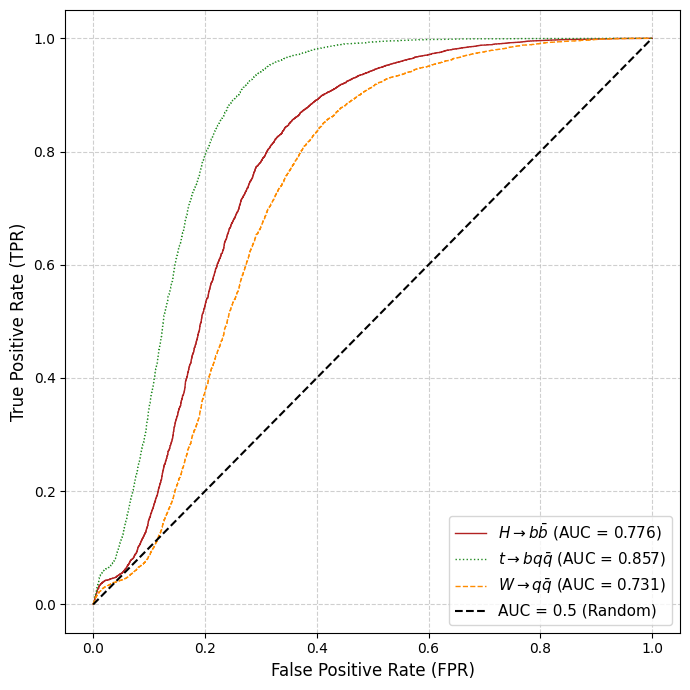

-------------------------------------------
KL Divergence (Qubits Real Fidelity)
-------------------------------------
HToBB || TTBar:  nan
TTBar || HToBB:  nan
WToQQ || HToBB: 0.022620665506836078
HToBB || WToQQ: 0.0221304162737243
WToQQ || TTBar: nan
TTBar || WToQQ: nan


/Users/mcarou/Documents/PhD/Proyecto/Research-Intership-Memory/python_env/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

qubits10 = np.load('./Qubits10.npz', allow_pickle=True)
qubits10_back = qubits10['fil_100_back_S']
qubits10_HToBB = qubits10['fil_100_HToBB_S']
qubits10_WToQQ = qubits10['fil_100_WToQQ_S']
qubits10_TTBar = qubits10['fil_100_TTBar_S']
qubits10_back = qubits10_back.squeeze()
qubits10_HToBB = qubits10_HToBB.squeeze()
qubits10_WToQQ = qubits10_WToQQ.squeeze()
qubits10_TTBar = qubits10_TTBar.squeeze()
# --- Anomaly scores (1 - Fidelity) ---
anomaly_scores_back = 1 - np.array(qubits10_back)
anomaly_scores_HToBB = 1 - np.array(qubits10_HToBB)
anomaly_scores_TTBar = 1 - np.array(qubits10_TTBar)
anomaly_scores_WToQQ = 1 - np.array(qubits10_WToQQ)

# --- Calcular AUC ---
auc_HToBB = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)

auc_TTBar = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)

auc_WToQQ = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)

print(f"AUC (QCD vs H→bb): {auc_HToBB:.4f}")
print(f"AUC (QCD vs t→bqq): {auc_TTBar:.4f}")
print(f"AUC (QCD vs W→qq): {auc_WToQQ:.4f}")

# --- Graficar curvas ROC ---
plt.figure(figsize=(7, 7))

# H→bb
fpr_HToBB, tpr_HToBB, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)
plt.plot(fpr_HToBB, tpr_HToBB, color='firebrick', linewidth=1,
         label=rf'$H \rightarrow b\bar{{b}}$ (AUC = {auc_HToBB:.3f})')

# t→bqq
fpr_TTBar, tpr_TTBar, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)
plt.plot(fpr_TTBar, tpr_TTBar, color='forestgreen', linewidth=1, linestyle=':',
         label=rf'$t \rightarrow bq\bar{{q}}$ (AUC = {auc_TTBar:.3f})')

# W→qq
fpr_WToQQ, tpr_WToQQ, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)
plt.plot(fpr_WToQQ, tpr_WToQQ, color='darkorange', linewidth=1, linestyle='--',
         label=rf'$W \rightarrow q\bar{{q}}$ (AUC = {auc_WToQQ:.3f})')

# Línea aleatoria (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', label=r'AUC = 0.5 (Random)')

# --- Personalización ejes y leyenda ---
plt.xlabel(r'False Positive Rate (FPR)', fontsize=12)
plt.ylabel(r'True Positive Rate (TPR)', fontsize=12)
#plt.title(r'ROC Curve ', fontsize=12, pad=5)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

# Ajuste márgenes y guardado
plt.tight_layout()
plt.savefig("metricas_rots2.png", dpi=300, bbox_inches='tight')
plt.show()

import numpy as np
from scipy.stats import entropy   # implementa KL divergence

def kl_divergence(p_samples, q_samples, bins=50):

    p_hist, bin_edges = np.histogram(p_samples, bins=bins, density=True)
    q_hist, _ = np.histogram(q_samples, bins=bin_edges, density=True)

    # evitar ceros (KL no está definida)
    p_hist += 1e-10
    q_hist += 1e-10

    return entropy(p_hist, q_hist)   # KL(p||q)

print("-------------------------------------------")
print("KL Divergence (Qubits Real Fidelity)")
print("-------------------------------------")

print("HToBB || TTBar: ", kl_divergence(qubits10_HToBB, anomaly_scores_TTBar))
print("TTBar || HToBB: ", kl_divergence(anomaly_scores_TTBar, qubits10_HToBB))

print("WToQQ || HToBB:", kl_divergence(qubits10_WToQQ, qubits10_HToBB))
print("HToBB || WToQQ:", kl_divergence(qubits10_HToBB, qubits10_WToQQ))

print("WToQQ || TTBar:", kl_divergence(qubits10_WToQQ, anomaly_scores_TTBar))
print("TTBar || WToQQ:", kl_divergence(anomaly_scores_TTBar, qubits10_WToQQ))

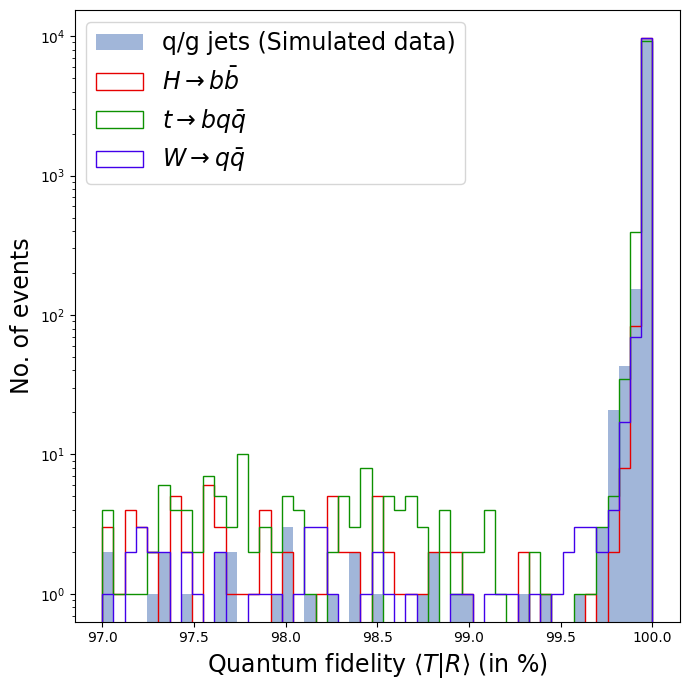

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

# Defining bins (from 97 to 100, as in the reference)
bins = np.linspace(97, 100, 50)

# Background: blue fill
plt.hist(qubits_back[-1].flatten(), 
         bins=bins, 
         histtype='stepfilled', 
         color="#7998CAB6", 
         alpha=0.7, 
         log=True,
         label=r'q/g jets (Simulated data)')

#  H → bb : 
plt.hist(qubits_HToBB[-1].flatten(), 
         bins=bins, 
         histtype='step', 
         color="#E60000", 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$H \rightarrow b\bar{b}$')

# t → bqq :
plt.hist(qubits_TTBar[-1].flatten(), 
         bins=bins, 
         histtype='step', 
         color='#0D9101', 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$t \rightarrow bq\bar{q}$')

#  W → qq : 
plt.hist(qubits_WToQQ[-1].flatten(), 
         bins=bins, 
         histtype='step', 
         color="#4200EA", 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum fidelity $\langle T|R \rangle$ (in %)', fontsize=17)
plt.ylabel(r'No. of events', fontsize=17)
#plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=17)
plt.tight_layout()
#plt.savefig("test_rots2.png", dpi=300, bbox_inches='tight')
plt.show()

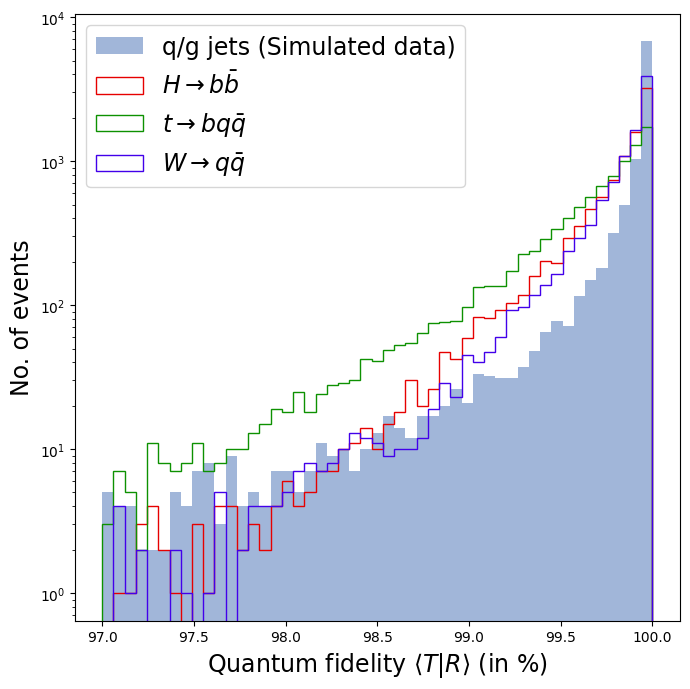

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

# Defining bins (from 97 to 100, as in the reference)
bins = np.linspace(97, 100, 50)

# Background: blue fill
plt.hist(qutritsd0dz_back[-1].flatten(), 
         bins=bins, 
         histtype='stepfilled', 
         color="#7998CAB6", 
         alpha=0.7, 
         log=True,
         label=r'q/g jets (Simulated data)')

#  H → bb : 
plt.hist(qutritsd0dz_HToBB[-1].flatten(), 
         bins=bins, 
         histtype='step', 
         color="#E60000", 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$H \rightarrow b\bar{b}$')

# t → bqq :
plt.hist(qutritsd0dz_TTBar[-1].flatten(), 
         bins=bins, 
         histtype='step', 
         color='#0D9101', 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$t \rightarrow bq\bar{q}$')

#  W → qq : 
plt.hist(qutritsd0dz_WToQQ[-1].flatten(), 
         bins=bins, 
         histtype='step', 
         color="#4200EA", 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum fidelity $\langle T|R \rangle$ (in %)', fontsize=17)
plt.ylabel(r'No. of events', fontsize=17)
#plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=17)
plt.tight_layout()
#plt.savefig("test_rots2.png", dpi=300, bbox_inches='tight')
plt.show()

qutritsTau12E_back = qutritsTau12E_back.squeeze()
qutritsTau12E_HToBB = qutritsTau12E_HToBB.squeeze()
qutritsTau12E_WToQQ = qutritsTau12E_WToQQ.squeeze()
qutritsTau12E_TTBar = qutritsTau12E_TTBar.squeeze()

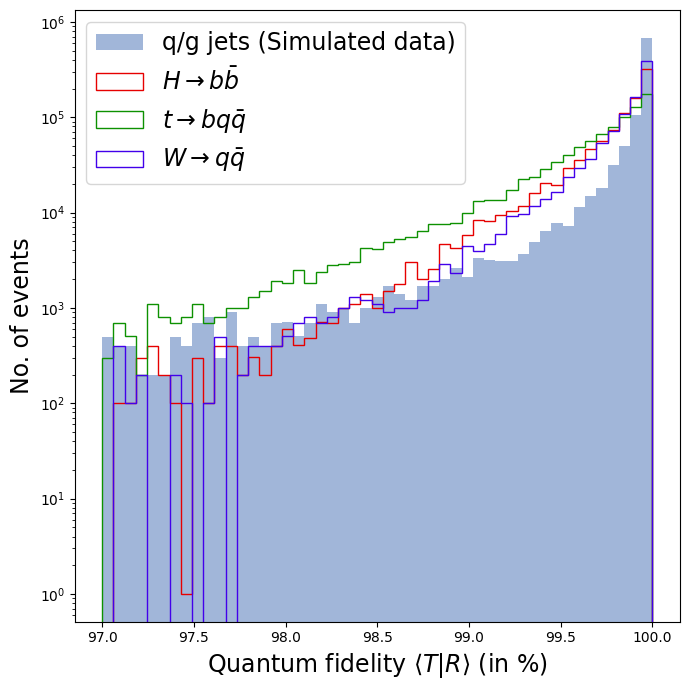

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

# Defining bins (from 97 to 100, as in the reference)
bins = np.linspace(97, 100, 50)

# Background: blue fill
plt.hist(qutritsd0dz_back.flatten(), 
         bins=bins, 
         histtype='stepfilled', 
         color="#7998CAB6", 
         alpha=0.7, 
         log=True,
         label=r'q/g jets (Simulated data)')

#  H → bb : 
plt.hist(qutritsd0dz_HToBB.flatten(), 
         bins=bins, 
         histtype='step', 
         color="#E60000", 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$H \rightarrow b\bar{b}$')

# t → bqq :
plt.hist(qutritsd0dz_TTBar.flatten(), 
         bins=bins, 
         histtype='step', 
         color='#0D9101', 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$t \rightarrow bq\bar{q}$')

#  W → qq : 
plt.hist(qutritsd0dz_WToQQ.flatten(), 
         bins=bins, 
         histtype='step', 
         color="#4200EA", 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum fidelity $\langle T|R \rangle$ (in %)', fontsize=17)
plt.ylabel(r'No. of events', fontsize=17)
#plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=17)
plt.tight_layout()
#plt.savefig("test_rots2.png", dpi=300, bbox_inches='tight')
plt.show()

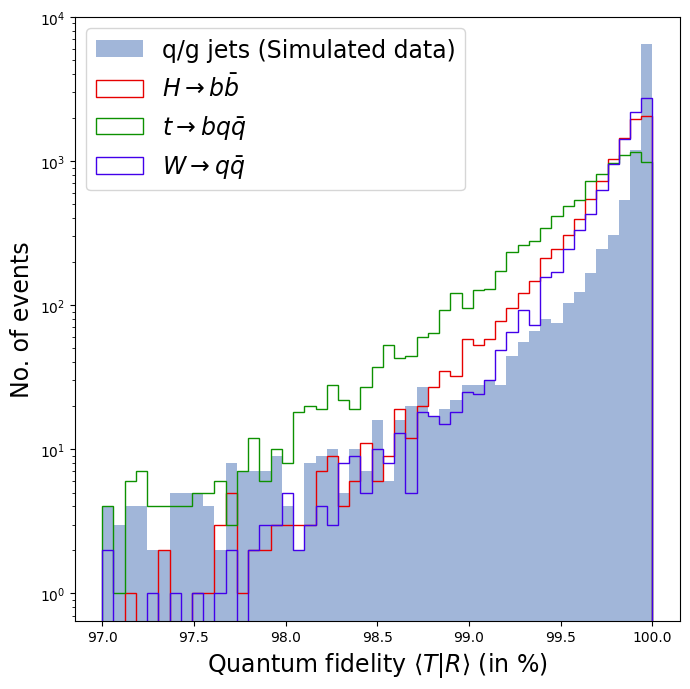

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

# Defining bins (from 97 to 100, as in the reference)
bins = np.linspace(97, 100, 50)

# Background: blue fill
plt.hist(qutritsTau12E_back[-1].flatten(), 
         bins=bins, 
         histtype='stepfilled', 
         color="#7998CAB6", 
         alpha=0.7, 
         log=True,
         label=r'q/g jets (Simulated data)')

#  H → bb : 
plt.hist(qutritsTau12E_HToBB[-1].flatten(), 
         bins=bins, 
         histtype='step', 
         color="#E60000", 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$H \rightarrow b\bar{b}$')

# t → bqq :
plt.hist(qutritsTau12E_TTBar[-1].flatten(), 
         bins=bins, 
         histtype='step', 
         color='#0D9101', 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$t \rightarrow bq\bar{q}$')

#  W → qq : 
plt.hist(qutritsTau12E_WToQQ[-1].flatten(), 
         bins=bins, 
         histtype='step', 
         color="#4200EA", 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum fidelity $\langle T|R \rangle$ (in %)', fontsize=17)
plt.ylabel(r'No. of events', fontsize=17)
#plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=17)
plt.tight_layout()
#plt.savefig("test_rots2.png", dpi=300, bbox_inches='tight')
plt.show()

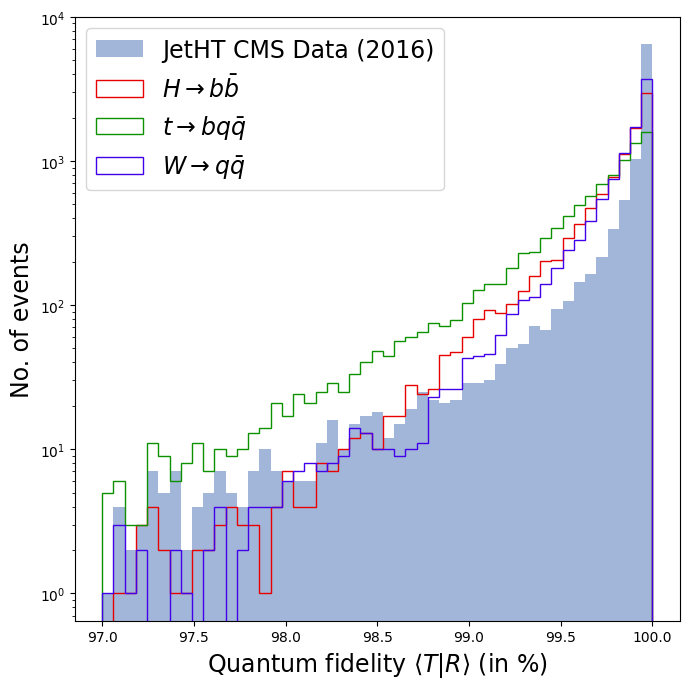

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

# Defining bins (from 97 to 100, as in the reference)
bins = np.linspace(97, 100, 50)

# Background: blue fill
plt.hist(qutritsReal_back[-1].flatten(), 
         bins=bins, 
         histtype='stepfilled', 
         color="#7998CAB6", 
         alpha=0.7, 
         log=True,
         label=r'JetHT CMS Data (2016)')

#  H → bb : 
plt.hist(qutritsReal_HToBB[-1].flatten(), 
         bins=bins, 
         histtype='step', 
         color="#E60000", 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$H \rightarrow b\bar{b}$')

# t → bqq :
plt.hist(qutritsReal_TTBar[-1].flatten(), 
         bins=bins, 
         histtype='step', 
         color='#0D9101', 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$t \rightarrow bq\bar{q}$')

#  W → qq : 
plt.hist(qutritsReal_WToQQ[-1].flatten(), 
         bins=bins, 
         histtype='step', 
         color="#4200EA", 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum fidelity $\langle T|R \rangle$ (in %)', fontsize=17)
plt.ylabel(r'No. of events', fontsize=17)
#plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=17)
plt.tight_layout()
#plt.savefig("test_rots2.png", dpi=300, bbox_inches='tight')
plt.show()

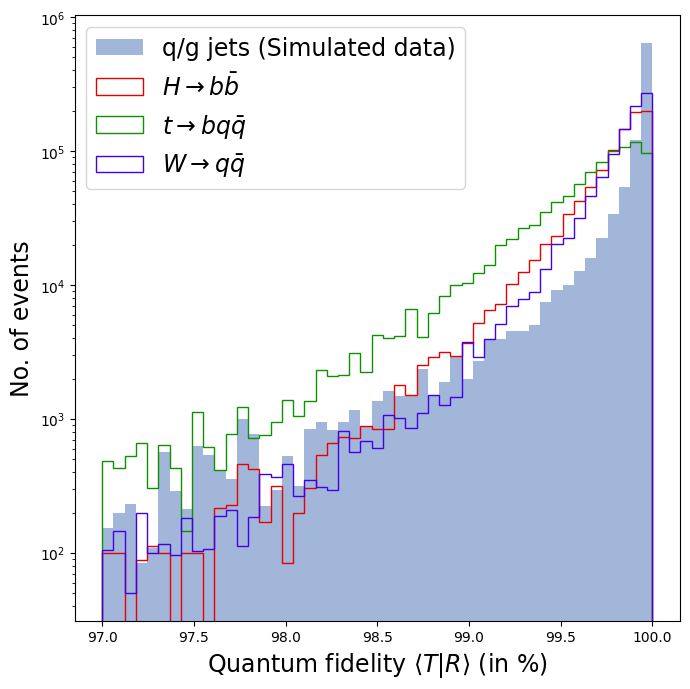

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

# Defining bins (from 97 to 100, as in the reference)
bins = np.linspace(97, 100, 50)

# Background: blue fill
plt.hist(qutritsTau34E_back.flatten(), 
         bins=bins, 
         histtype='stepfilled', 
         color="#7998CAB6", 
         alpha=0.7, 
         log=True,
         label=r'q/g jets (Simulated data)')

#  H → bb : 
plt.hist(qutritsTau34E_HToBB.flatten(), 
         bins=bins, 
         histtype='step', 
         color="#E60000", 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$H \rightarrow b\bar{b}$')

# t → bqq :
plt.hist(qutritsTau34E_TTBar.flatten(), 
         bins=bins, 
         histtype='step', 
         color='#0D9101', 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$t \rightarrow bq\bar{q}$')

#  W → qq : 
plt.hist(qutritsTau34E_WToQQ.flatten(), 
         bins=bins, 
         histtype='step', 
         color="#4200EA", 
         linewidth=1, 
         linestyle='-', 
         log=True,
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum fidelity $\langle T|R \rangle$ (in %)', fontsize=17)
plt.ylabel(r'No. of events', fontsize=17)
#plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=17)
plt.tight_layout()
#plt.savefig("test_rots2.png", dpi=300, bbox_inches='tight')
plt.show()

## **Dispersion Analysis**

From this point onward, we will analyze how dispersed the results are among the different datasets results. 
This helps to understand the variability and consistency of the computed metrics.


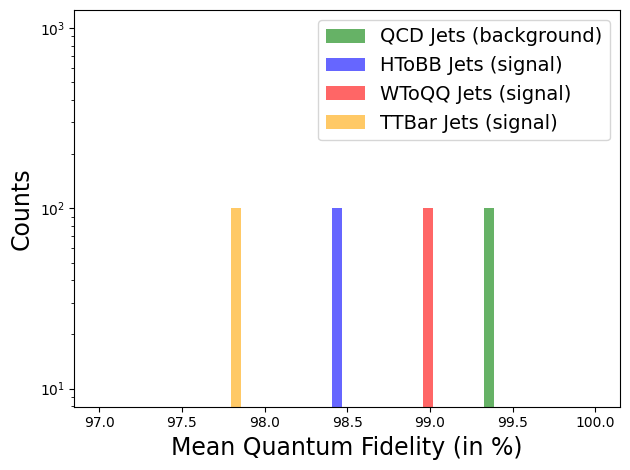

In [ ]:
bins = np.linspace(97, 100, 50)
plt.hist(means_back_qutritsd0dz, bins=bins,  alpha=0.6, color='g', label='QCD Jets (background)', log=True)
plt.hist(means_HToBB_qutritsd0dz, bins=bins,  alpha=0.6, color='b', label='HToBB Jets (signal)', log=True)
plt.hist(means_WToQQ_qutritsd0dz, bins=bins,  alpha=0.6, color='r', label='WToQQ Jets (signal)', log=True)
plt.hist(means_TTBar_qutritsd0dz, bins=bins,  alpha=0.6, color='orange', label='TTBar Jets (signal)', log=True)
plt.xlabel('Mean Quantum Fidelity (in %)', fontsize=17)
plt.ylabel('Counts', fontsize=17)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

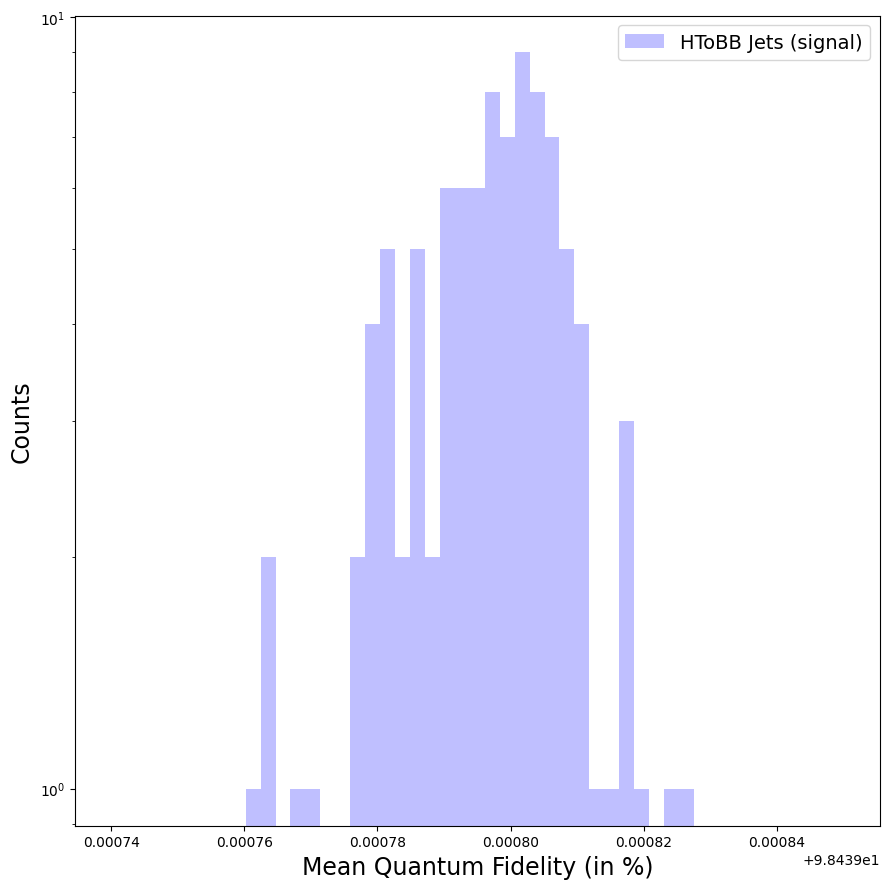

In [ ]:
plt.figure(figsize=(9, 9))
bins = np.linspace(98.43974, 98.43985, 50)
#plt.hist(means_back_qutritsd0dz, bins=bins,  alpha=0.6, color='g', label='QCD Jets (background)', log=True)
plt.hist(means_HToBB_qutritsd0dz, bins=bins,  alpha=0.25, color='b', label='HToBB Jets (signal)', log=True)
#plt.hist(means_WToQQ_qutritsd0dz, bins=bins,  alpha=0.6, color='r', label='WToQQ Jets (signal)', log=True)
#plt.hist(means_TTBar_qutritsd0dz, bins=bins,  alpha=0.6, color='orange', label='TTBar Jets (signal)', log=True)
plt.xlabel('Mean Quantum Fidelity (in %)', fontsize=17)
plt.ylabel('Counts', fontsize=17)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

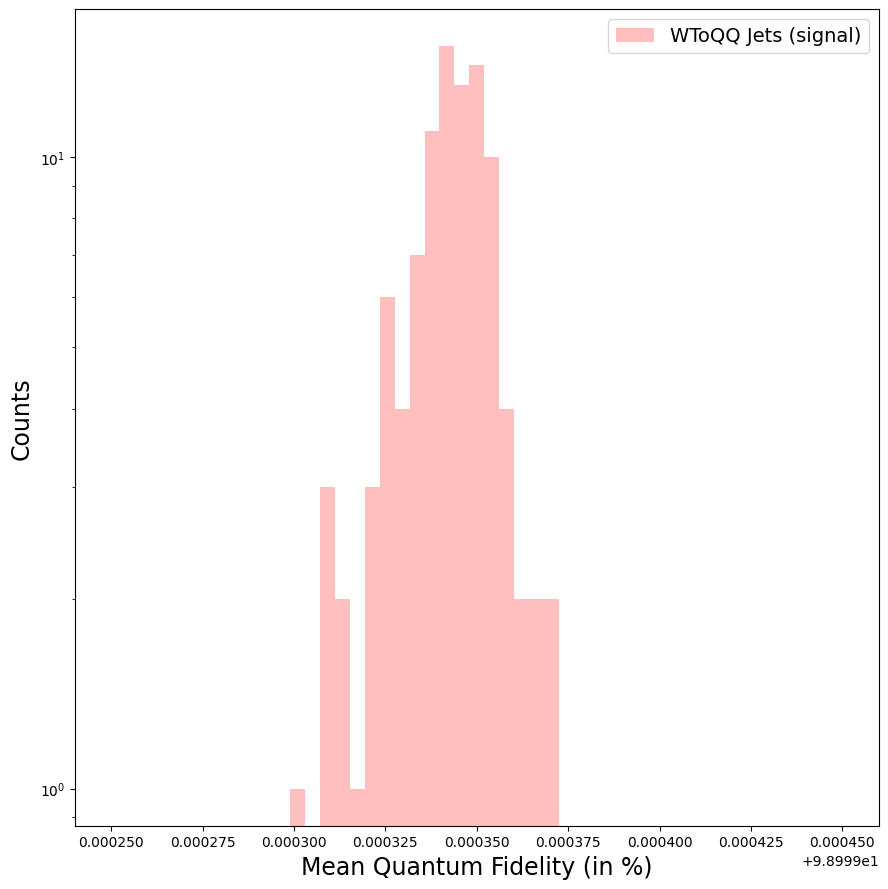

In [ ]:
plt.figure(figsize=(9, 9))
bins = np.linspace(98.99925, 98.99945, 50)
#plt.hist(means_back_qutritsd0dz, bins=bins,  alpha=0.6, color='g', label='QCD Jets (background)', log=True)
#plt.hist(means_HToBB_qutritsd0dz, bins=bins,  alpha=0.6, color='b', label='HToBB Jets (signal)', log=True)
plt.hist(means_WToQQ_qutritsd0dz, bins=bins,  alpha=0.25, color='r', label='WToQQ Jets (signal)', log=True)
#plt.hist(means_TTBar_qutritsd0dz, bins=bins,  alpha=0.6, color='orange', label='TTBar Jets (signal)', log=True)
plt.xlabel('Mean Quantum Fidelity (in %)', fontsize=17)
plt.ylabel('Counts', fontsize=17)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

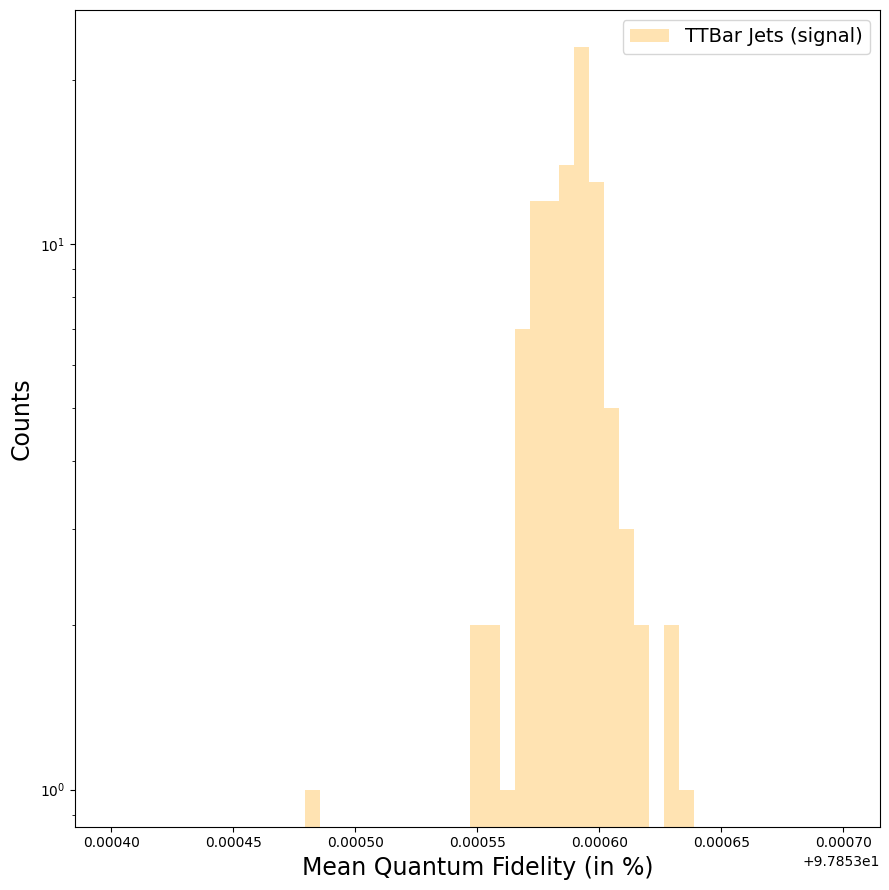

In [ ]:
plt.figure(figsize=(9, 9))
bins = np.linspace(97.8534, 97.8537, 50)
#plt.hist(means_back_qutritsd0dz, bins=bins,  alpha=0.6, color='g', label='QCD Jets (background)', log=True)
#plt.hist(means_HToBB_qutritsd0dz, bins=bins,  alpha=0.6, color='b', label='HToBB Jets (signal)', log=True)
#plt.hist(means_WToQQ_qutritsd0dz, bins=bins,  alpha=0.6, color='r', label='WToQQ Jets (signal)', log=True)
plt.hist(means_TTBar_qutritsd0dz, bins=bins,  alpha=0.3, color='orange', label='TTBar Jets (signal)', log=True)
plt.xlabel('Mean Quantum Fidelity (in %)', fontsize=17)
plt.ylabel('Counts', fontsize=17)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()